In [1]:
import sys
import os
os.environ['BACKEND'] = 'numpy'


import numpy as np
import pandas as pd 
import numba
from numba import njit, prange
from typing import List, Tuple, Sequence, Dict, Any, Union
import time

# Add the parent directory (project root) to sys.path
script_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(script_dir, '..', '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# ------------------------------------------------------------------
#! General
from QES.general_python.common.timer import Timer, timeit
from QES.general_python.common.binary import get_global_logger, Array
from QES.general_python.common import Plotter, MatrixPrinter, colorsCycle, linestylesCycle
from QES.general_python.common import Directories
# from QES.general_python.common.hdf5_lib import HDF5Handler, read_hdf5_extract_and_concat_list
from QES.general_python.common.hdf5man import HDF5Manager
from QES.general_python.maths.statistics import HistogramAverage, Fraction
from QES.general_python.physics import entropy, density_matrix

# ------------------------------------------------------------------
from QES.Algebra.Model.Interacting.Spin.ultrametric import UltrametricModel
from QES.Algebra.hilbert import HilbertSpace

# ------------------------------------------------------------------
from QES.Algebra.Properties import time_evo
from QES.Algebra.Properties import statistical
from QES.general_python.algebra.linalg import act, overlap, overlap_diag

# ------------------------------------------------------------------
import QES.Algebra.Operator.operators_spin as op_spin

logger      = get_global_logger()

# ------------------------------------------------------------------
data_dir = Directories(os.curdir, 'data_add')
data_dir = Directories(os.curdir, 'data_big_times')
# data_dir.mkdir()


26_05_2025_11-56_12 [INFO] Log file created: ./log/QES_26_05_2025_11-56_12.log
26_05_2025_11-56_12 [INFO] Log level set to: info
26_05_2025_11-56_12 [INFO] ############Global logger initialized.############
26_05_2025_11-56_12 [INFO] JAX is not available. Using NumPy as the active backend.
26_05_2025_11-56_12 [INFO] **************************************************
26_05_2025_11-56_12 [INFO] Backend Configuration:
26_05_2025_11-56_12 [INFO] 		NumPy Version: 1.26.4
26_05_2025_11-56_12 [INFO] 		SciPy Version: 1.13.1
26_05_2025_11-56_12 [INFO] 		JAX Version: Not Available
26_05_2025_11-56_12 [INFO] 		Active Backend: numpy
26_05_2025_11-56_12 [INFO] 			JAX Available: False
26_05_2025_11-56_12 [INFO] 			Default Seed: 42
26_05_2025_11-56_12 [INFO] 		NumPy Backend Details:
26_05_2025_11-56_12 [INFO] 				Main Module: numpy
26_05_2025_11-56_12 [INFO] 				Random Module: Generator
26_05_2025_11-56_12 [INFO] 				SciPy Module: scipy
26_05_2025_11-56_12 [INFO] 		Active Data Types:
26_05_2025_11-56_

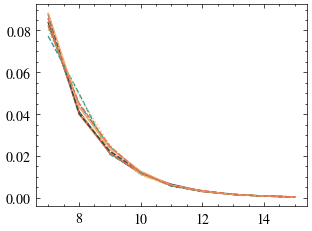

In [2]:
rng                 = np.random.default_rng()
rand_num            = rng.integers(0, int(1e5))

bw_df               = pd.read_csv("model/bw.csv", index_col=0, header=None, dtype=float)
mls_df              = pd.read_csv("model/mls.csv", index_col=0, header=None, dtype=float)
bw_df.index         = [f'{x:.2f}' for x in bw_df.index]
mls_df.index        = [f'{x:.2f}' for x in mls_df.index]
bw_df.columns       = list(range(7, 17))
mls_df.columns      = list(range(7, 16))

for i in range(len(bw_df.columns)):
    mls_df.iloc[i].plot(label=f'{bw_df.index[i]}', linestyle=next(linestylesCycle))


In [3]:

def align_and_stack(xs         : Sequence[np.ndarray],
                    ys         : Sequence[np.ndarray],
                    fill_value : float      = np.nan,
                    shared_x   : np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Align multiple (x, y) samples onto their union x-axis and stack
    the y-arrays, filling gaps with fill_value.

    Parameters
    ----------
    xs
        Sequence of 1D arrays of x-coordinates.
    ys
        Sequence of 1D arrays of y-values; must have same length as xs.
    fill_value
        Scalar to use where a sample has no y at a given union-x.

    Returns
    -------
    x_union : np.ndarray, shape (F,)
        Sorted unique union of all x-values.
    Y       : np.ndarray, shape (N, F)
        Stacked y-values for N samples, aligned to x_union.
    """
    if shared_x is None:
        if len(xs) != len(ys):
            raise ValueError("`xs` and `ys` must have the same number of samples")
    else:
        logger.info("Using shared x-axis, it gives us indices in samples in y for a given x", lvl=1)
        logger.info(f"Shared x-axis: {shared_x}", lvl=2)
        
    # compute sorted union of all x
    x_union     = np.unique(np.concatenate(xs))
    print(f"Union x-axis: {x_union}")
    n_samples   = len(ys)
    n_columns   = x_union.size

    # allocate output array
    Y           = np.full((n_samples, n_columns), fill_value, dtype=ys[0].dtype if hasattr(ys[0], 'dtype') else float)
    print(f"Y shape: {Y.shape}")

    # fill each row by searching where its x_i lands in x_union
    idx_in_x    = 0
    for i in range(n_samples):
        print(f"\tSample {i}")
        if shared_x is not None:
            # move to the next sample in y
            if i >= shared_x[idx_in_x]:
                idx_in_x    +=   1
            print(f"\t\tidx_in_x: {idx_in_x}")
            x_i = xs[idx_in_x]
            y_i = ys[i]
        else:
            x_i = xs[i]
            y_i = ys[i]            
            
        idx         = np.searchsorted(x_union, x_i)
        Y[i, idx]   = y_i

    return x_union, Y

x1 = [0, 1, 2, 3, 4]
y1 = [1] * 5
y12= [5] * 5
x2 = [1, 2, 3, 4, 5, 6]
y2 = [2] * 6
y3 = [3] * 6

# align_and_stack(
#     [x1, x2],
#     [y1, y12, y2, y3],
#     fill_value=np.nan,
#     shared_x=[2, 4]
# )

# def sum_previous()


Time evolution readout

```python
    data_out = {
        'evolution'     : (data_evo_time, data_evo_av, data_evo_av_rm, data_evo_d_av),
        'distribution'  : ((distr_bins, distr), (distr_bins_rm, distr_rm)),
        'moments'       : ((mu, mu2, mu3, mu4), (mu_rm, mu2_rm, mu3_rm, mu4_rm)),
        'fft'           : (data_evo_fft_om, data_evo_fft, data_evo_fft_n)
    }
```
    

In [4]:
def read_time_evolution_uniform(
            directories     : List[Directories],
            alpha           : float,
            ns              : int,
            n               : int,
            operator        : str,
            window          : int = 31,
        ):
    
    #! keys for Python data
    time_key        = '/time'
    time_evo_key    = f'/time_evolution/{operator}/expectation'
    time_evo_d_key  = f'/time_evolution/{operator}/diag_ens'
    model           = UltrametricModel(ns = ns, n = n, alphas = alpha)
    modelstr        = str(model)
    directories     = [Directories(d, modelstr) for d in directories]
    filelist        = [x for d in directories for x in d.list_files(filters = [lambda x: str(x).endswith('h5')])]
    filelist_time   = [str(x) for x in filelist if "evo_" in str(x)]

    #! read data from the Python files
    if len(filelist_time):
        data_evo_time           = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_time, dataset_keys=[time_key])
        data_evo_time           = [x[time_key] for x in data_evo_time][0] # same time for all files
        logger.info(f"data_evo_time shape: {data_evo_time.shape}", lvl=2, color='blue')
        
        data_evo_all            = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_time, dataset_keys=[time_evo_key])
        data_evo_all            = [x[time_evo_key] for x in data_evo_all]
        data_evo_samples        = [len(x) for x in data_evo_all]
        logger.info(f"data_evo_samples: {data_evo_samples} for {modelstr}", lvl=3, color='blue')

        data_evo_all            = [y for x in data_evo_all for y in x if y.shape[0] > 0]
        data_evo_all            = np.array(data_evo_all, dtype=float)
        logger.info(f"reshaped to: {data_evo_all.shape}", lvl=4, color='blue')
        # data_evo_av             = data_evo_av.reshape(-1, data_evo_av.shape[-1], order='C')
        
        #! diagonal ensemble
        data_evo_d_av           = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_time, dataset_keys=[time_evo_d_key])
        data_evo_d_av           = [x[time_evo_d_key] for x in data_evo_d_av]
        data_evo_d_av           = [y for x in data_evo_d_av for y in x]
        data_evo_d_av           = np.array(data_evo_d_av, dtype=float)
        # data_evo_d_av           = np.array([x[time_evo_d_key] for x in data_evo_d_av]).flatten()

        #! remove diagonal ensemble
        data_evo_av             = data_evo_all - data_evo_d_av[:, np.newaxis]

        #! remove structure
        data_evo_av_rm          = statistical.spectral_structure(data_evo_av, window = window)
        
    else:
        return None
    
    #! create the distribution of the data
    distr, distr_bins       = np.histogram(data_evo_av, bins=100, density=True)
    distr_bins              = 0.5 * (distr_bins[1:] + distr_bins[:-1])
    
    distr_rm, distr_bins_rm = np.histogram(data_evo_av_rm, bins=100, density=True)
    distr_bins_rm           = 0.5 * (distr_bins_rm[1:] + distr_bins_rm[:-1])
    
    #! moments of the values
    mu, mu2, mu3, mu4       = np.mean(data_evo_av, axis = 1),   \
                            np.mean(data_evo_av**2, axis = 1),  \
                            np.mean(data_evo_av**3, axis = 1),  \
                            np.mean(data_evo_av**4, axis = 1)
    
    mu_rm, mu2_rm, mu3_rm, mu4_rm = np.mean(data_evo_av_rm, axis = 1),   \
                            np.mean(data_evo_av_rm**2, axis = 1),  \
                            np.mean(data_evo_av_rm**3, axis = 1),  \
                            np.mean(data_evo_av_rm**4, axis = 1)
    
    #! FFT
    time_delta              = data_evo_time[1] - data_evo_time[0]
    time_num                = data_evo_time.shape[-1]
    time_norm               = 2 / np.sqrt(time_num)
    data_evo_fft_om         = np.fft.fftfreq(time_num, d=time_delta)[1:time_num//2] * 2 * np.pi
    data_evo_fft_base       = np.fft.fft(data_evo_av, axis=1)[:, 1:time_num//2] * time_norm
    data_evo_fft            = np.abs(data_evo_fft_base)**2 / data_evo_time.shape[0]**2
    data_evo_fft            = np.mean(data_evo_fft, axis = 0)
    data_evo_fft_n          = np.trapz(data_evo_fft, x=data_evo_fft_om, axis=0)
    data_evo_fft            = data_evo_fft / data_evo_fft_n
    
    logger.info(f"time delta: {time_delta}, time num: {time_num}, shape: {data_evo_fft_om.shape}", lvl = 2)
    logger.info(f"data_evo_fft shape: {data_evo_fft.shape}", lvl = 3, color = 'blue')
    
    data_out = {
        'evolution'     : (data_evo_time, data_evo_av, data_evo_av_rm, data_evo_d_av),
        'distribution'  : ((distr_bins, distr), (distr_bins_rm, distr_rm)),
        'moments'       : ((mu, mu2, mu3, mu4), (mu_rm, mu2_rm, mu3_rm, mu4_rm)),
        'fft'           : (data_evo_fft_om, data_evo_fft, data_evo_fft_n)
    }
    
    return data_out

Read the energy of the system
```python
data_out = {
    'energy'                    : (data_energy, mean_lvl_spacing, bandwidth_data),
    'ldos'                      : data_ldos,
    'iprs'                      : iprs,
    'participation_entropies'   : participation_entropies,
}
```

In [5]:
def read_energy(
            directories     : List[Directories],
            alpha           : float,
            ns              : int,
            n               : int,
        ):
    
    #! keys for Python data
    energy_key      = '/energies'
    ldos_key        = '/ldos'
    model           = UltrametricModel(ns = ns, n = n, alphas = alpha)
    modelstr        = str(model)
    directories     = [Directories(d, modelstr) for d in directories]
    filelist        = [x for d in directories for x in d.list_files(filters = [lambda x: str(x).endswith('h5')])]
    filelist_energy = [str(x) for x in filelist if "stat_" in str(x) or "energy_" in str(x)]

    #! read data from the Python files
    if len(filelist_energy):
        data_energy             = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_energy, dataset_keys=[energy_key])
        data_energy             = [x[energy_key] for x in data_energy]
        data_energy             = [y for x in data_energy for y in x if y.shape[0] > 0] # flatten and remove empty arrays
        data_energy             = np.array(data_energy, dtype=float)
        # data_energy             = data_energy.reshape(-1, data_energy.shape[-1], order='C')
        mean_lvl_spacing        = np.mean(np.mean(np.diff(data_energy, axis=1), axis = 1), axis=0)
        bandwidth_data          = np.mean(np.var(data_energy, axis=1), axis=0)
        
        #! LDOS
        data_ldos               = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_energy, dataset_keys=[ldos_key])
        data_ldos               = [x[ldos_key] for x in data_ldos]
        data_ldos               = [y for x in data_ldos for y in x if y.shape[0] > 0]
        data_ldos               = np.array(data_ldos, dtype=float)
        # data_ldos               = data_ldos.reshape(-1, data_ldos.shape[-1], order='C')

        #! IPRS from the LDOS
        qs                      = [0.5, 1.0, 2.0, 3.0, 4.0] # divide by 2, as we have the LDOS, which is already squared
        iprs                    = { q: statistical.inverse_participation_ratio(data_ldos, q = q / 2) for q in qs }
        participation_entropies = { q: entropy.participation_entropy(data_ldos, q = q / 2) for q in qs }
        
        #! Reduced density matrix - damn, we have abs**2...
        # subsystems              = ((2, 2**(ns-1)), (2**(ns // 2), 2**(ns // 2)))
        # for (dimA, dimB) in subsystems:
        #     rho                 = [density_matrix.rho_numba(ov, dimA=dimA, dimB=2**(ns - 1)) for ov in overlaps]
        #     #! calculate the entropies for the initial state in the eigenbasis
        #     schmidt_val, _      = density_matrix.schmidt_numba(rho, 2, 2**(ns - 1), eig = False)
    else:
        return None
    
    data_out = {
        'energy'                    : (data_energy, mean_lvl_spacing, bandwidth_data),
        'ldos'                      : data_ldos,
        'iprs'                      : iprs,
        'participation_entropies'   : participation_entropies,
    }

    return data_out

Read the spectral functions
```python
data_out                = {
    'histogram' : ((data_hist_bins, data_hist_av), (data_hist_typ, data_hist_count)),
    'cdf'       : (oms, smooth, cdf, g),
    'cdf_typ'   : (omst, smootht, cdft, gt)
}
```

In [12]:
def read_histogram(
            directories     : List[Directories],
            alpha           : float,
            ns              : int,
            n               : int,
            operator        : str,
            window          : int = 31,
        ):
    
    #! keys for Python data
    hist_key        = f'/historgram/{operator}/average/values'
    hist_typ_key    = f'/historgram/{operator}/typical/values'
    hist_count_key  = '/historgram/counts'
    hist_edges_key  = '/historgram/edges'
    model           = UltrametricModel(ns = ns, n = n, alphas = alpha)
    modelstr        = str(model)
    directories     = [Directories(d, modelstr) for d in directories]
    filelist        = [x for d in directories for x in d.list_files(filters = [lambda x: str(x).endswith('h5')])]
    filelist_hist   = [str(x) for x in filelist if "hist_" in str(x)]
    
    if len(filelist_hist):
        data_hist_bins          = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_edges_key])
        data_hist_bins          = np.mean([x[hist_edges_key] for x in data_hist_bins], axis=0) #! bins should be the same for all files

        #! read the histogram data
        
        # average
        data_hist_av            = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_key])
        data_hist_av            = np.mean([x[hist_key] for x in data_hist_av], axis=0)
        mask                    = (data_hist_av > 1e-10) & np.isfinite(data_hist_av)
        if mask.any():
            data_hist_av         = data_hist_av[mask] # remove zeros
            data_hist_bins       = data_hist_bins[mask]
        else:
            data_hist_av         = np.zeros_like(data_hist_bins)
            data_hist_bins       = data_hist_bins
            
        # typical
        data_hist_typ           = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_typ_key])
        data_hist_typ           = np.mean([(x[hist_typ_key]) for x in data_hist_typ], axis=0)
        data_hist_typ           = np.exp(data_hist_typ) # convert to log scale
        # mask                    = (data_hist_typ < -1e-10) & np.isfinite(data_hist_typ)
        # if mask.any():
            # data_hist_typ       = np.exp(data_hist_typ[mask]) # convert to probability density
            # data_hist_typ_bins  = data_hist_bins[mask]
        # else:
            # data_hist_typ       = np.zeros_like(data_hist_bins)
            # data_hist_typ_bins  = data_hist_bins

        # counts
        data_hist_count         = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_count_key])
        data_hist_count         = np.mean([x[hist_count_key] for x in data_hist_count], axis=0)
        
        #! normalize
        # data_hist_av            = data_hist_av / np.trapz(data_hist_av, x=data_hist_bins)
        # data_hist_typ           = data_hist_typ / np.trapz(data_hist_typ, x=data_hist_bins)

        oms, smooth, cdf, g     = statistical.spectral_cdf(data_hist_bins, data_hist_av, BINVAL=window)
        omst, smootht, cdft, gt = statistical.spectral_cdf(data_hist_bins, data_hist_av, BINVAL=window)
        
        data_out                = {
            'histogram' : ((data_hist_bins, data_hist_av), (data_hist_bins, data_hist_typ), data_hist_count),
            'cdf'       : (oms, smooth, cdf, g),
            'cdf_typ'   : (omst, smootht, cdft, gt)
        }
        return data_out
    return None

In [7]:
def extract_k_functions(data_ldos, data_energy, data_hist_bins, energies_at = None):
    """
    Extract k-functions from the LDOS and energy data.

    Parameters
    ----------
    data_ldos : np.ndarray
        The LDOS data.
    data_energy : np.ndarray
        The energy data.
    data_hist_bins : np.ndarray
        The histogram bins.
    energies_at : np.ndarray, optional
        Specific energies to extract k-functions at.

    Returns
    -------
    k_functions : Dict[str, np.ndarray]
        Dictionary with k-functions for each energy.
    """
    if energies_at is None:
        energies_at = np.mean(data_energy, axis = 1)  # Use mean energy if not specified
    
    k_function_list         = [statistical.k_function(data_ldos[i], data_energy[i], data_hist_bins, energies_at[i]) for i in range(len(data_energy))]
    k_functions             = np.array([x[0] for x in k_function_list])
    k_counts                = np.array([x[1] for x in k_function_list])
    k_counts[k_counts == 0] = 1
    k_functions             = (k_functions / k_counts)
    k_functions             = np.mean(k_functions, axis=0)
    # k_functions             = k_functions / np.trapz(k_functions, x=data_hist_bins[1:])
    return k_functions, k_counts

In [8]:
def extract_k_times_o2(k_functions, data_hist, data_hist_bins):
    '''
    Extract k-functions for the O2 operator from the histogram data.
    Parameters
    ----------
    k_functions : np.ndarray
        The k-functions extracted from the LDOS and energy data.
    data_hist : np.ndarray
        The histogram data - spectral function.
    data_hist_bins : np.ndarray
        The histogram bins.
    Returns
    -------
    k_times_hist : np.ndarray
        The k-functions multiplied by the histogram data.
    k_times_hist_norm : float
        The normalization factor for the k-functions multiplied by the histogram data.
    '''
    k_times_hist            = k_functions * data_hist[1:]
    k_times_hist_norm       = np.trapz(k_times_hist, x=data_hist_bins[1:])
    k_times_hist           /= k_times_hist_norm
    return k_times_hist, k_times_hist_norm

In [16]:
import matplotlib.pyplot as plt
colors_map, norm, cmap = Plotter.get_colormap(np.arange(8, 15, dtype = int), 'viridis_r')

def get_results_single(directories_python   : List[Directories],
                    alpha                   : float,
                    ns                      : int,
                    n                       : int,
                    uniform                 : bool = False,
                    operator                : str  = 'Sz/0'):
    
    logger.info(f"alpha: {alpha:.2f}, ns: {ns}, n: {n}, uniform: {uniform}, operator: {operator}", color='red')
    fig, ax         = Plotter.get_subplots(nrows = 1, ncols = 5, figsize = (15, 3), dpi = 150)
    fig.suptitle(f"$\\alpha={alpha:.2f}, L={ns-n}$")
    
    color_ns        = colors_map(ns)
    mean_lvl        = mls_df.loc[f'{alpha:.2f}', ns]
    mean_lvl_lim    = mean_lvl / 50
    logger.info(f"mean level: {mean_lvl}", lvl = 2)

    # --------------------------------------------------------
    #! energy
    data = read_energy(directories  = directories_python,
                    alpha           = alpha,
                    ns              = ns,
                    n               = n)
    (data_energy, mean_lvl_spacing, bandwidth_data) = data['energy']
    data_ldos                                       = data['ldos']
    iprs, participation_entropies                   = data['iprs'], data['participation_entropies']
    Plotter.vline(ax[0], mean_lvl_spacing, label=r'$\Delta$', ls='--', color = 'black')
    Plotter.vline(ax[2], mean_lvl_spacing, label=r'$\Delta$', ls='--', color = 'black')
    Plotter.vline(ax[3], mean_lvl_spacing, label=r'$\Delta$', ls='--', color = 'black')
    logger.info(f"mean level spacing true: {mean_lvl_spacing}", lvl = 2)
    
    # --------------------------------------------------------
    #! spectral functions
    data = read_histogram(directories   = directories_python,
                        alpha           = alpha,
                        ns              = ns,
                        n               = n,
                        operator        = operator)
    ((data_hist_bins, data_hist_av), (data_hist_bins, data_hist_typ), data_hist_count)  = data['histogram']
    (oms, smooth, cdf, g)                                                               = data['cdf']
    (omst, smootht, cdft, gt)                                                           = data['cdf_typ']
    
    ax[0].stairs(data_hist_av[1:], data_hist_bins, label=r'$O^2(\omega)$', ls=next(linestylesCycle), color = 'red')
    Plotter.vline(ax[0], g, label=r'$\Gamma$', ls='--', color = 'green', lw = 1.5)
    Plotter.plot(ax[3], oms, smooth, label=r'$O^2(\omega)$', ls='--', color = 'red')
    
    #! twinax
    ax3_twiny = ax[3].twinx()
    ax3_twiny.set_ylim(0, 1)
    Plotter.plot(ax3_twiny, oms, cdf, label=r'$cdf[O^2(\omega)]$', ls=next(linestylesCycle), color = 'blue')
    # Plotter.set_ax_params(ax3_twiny, xlabel=r'$\omega$', ylabel=r'$cdf[O^2(\omega)]$', xscale='log', yscale='linear', xlim=(mean_lvl_lim, None), ylim=(0, 1))
    
    # ax[3].plot(omegas2, y_smoothed2, label=r'typ[$O^2(\omega)$]', ls=next(linestylesCycle), color = 'purple')
    ax[2].axvline(g, label=r'$\Gamma$', ls='--', color = 'green')
    ax[3].axvline(g, label=r'$\Gamma$', ls='--', color = 'green')

    # --------------------------------------------------------
    #! time evolution
    data = read_time_evolution_uniform(directories      = directories_python,
                                        alpha           = alpha,
                                        ns              = ns,
                                        n               = n,
                                        operator        = operator)
    (data_evo_time, data_evo_av, data_evo_av_rm, data_evo_d_av) = data['evolution']
    (distr_bins, distr)                                         = data['distribution'][0]
    (distr_bins_rm, distr_rm)                                   = data['distribution'][1]
    (mu, mu2, mu3, mu4)                                         = data['moments'][0]
    moms                                                        = np.array([mu, mu2, mu3, mu4], dtype=float)
    (mu_rm, mu2_rm, mu3_rm, mu4_rm)                             = data['moments'][1]
    moms_rm                                                     = np.array([mu_rm, mu2_rm, mu3_rm, mu4_rm], dtype=float)
    (data_evo_fft_om, data_evo_fft, data_evo_fft_n)             = data['fft']

    Plotter.plot(ax[1], data_evo_time, np.mean(data_evo_av, axis = 0) + 1, label=r'$\tilde{C}(t) + 1$', color = color_ns)
    Plotter.plot(ax[1], data_evo_time, np.mean(data_evo_av_rm, axis = 0) + 1, label=r'$\tilde{C}(t)_{\rm MA} + 1$', color = 'black')
    Plotter.plot(ax[4], distr_bins, distr, label=r'$P(\tilde{C}(t))$', ls=next(linestylesCycle), color = color_ns)
    Plotter.plot(ax[0], data_evo_fft_om, data_evo_fft, label=r'$\tilde{S}(\omega)$', ls='-', color = color_ns)
    Plotter.plot(ax[2], data_evo_fft_om, data_evo_fft, label=r'$\tilde{S}(\omega)$', ls='-', color = color_ns)

    # --------------------------------------------------------
    #! k-functions
    k_functions, k_counts   = extract_k_functions(data_ldos, data_energy, data_hist_bins)
    ax[0].stairs(k_functions, data_hist_bins, label=r'$K(\omega)$', linestyle=":", color = 'black')
    
    # --------------------------------------------------------
    #! multiply k and histograms together
    k_times_hist, k_times_hist_norm = extract_k_times_o2(k_functions, data_hist_av, data_hist_bins)
    ax[2].stairs(k_times_hist, data_hist_bins, label=r'$K(\omega) \cdot O^2(\omega)$', ls='--', color = 'black', lw = 1.5)

    #! -------------------------------------------------------
    Plotter.set_ax_params(ax[0], xlabel=r'$\omega$', ylabel=r'$\tilde{S}(\omega)$', xscale='log', yscale='log', xlim=(mean_lvl_lim, 1e1))
    Plotter.set_ax_params(ax[1], xlabel=r'$t$', ylabel=r'$(C(t)-C_{\rm diag}) + 1$', xscale='log', yscale='log')
    Plotter.set_ax_params(ax[2], xlabel=r'$\omega$', ylabel=r'$K(\omega) O^2(\omega)$', xscale='log', yscale='log', xlim=(mean_lvl_lim, 1e1))
    Plotter.set_ax_params(ax[3], xlabel=r'$\omega$', ylabel=r'$cdf[O^2(\omega)]$', xscale='log', yscale='log', xlim=(mean_lvl_lim, 1e1))
    Plotter.set_ax_params(ax[4], xlabel=r'$\tilde{C}(t)$', ylabel=r'$P(\tilde{C}(t))$', xscale='linear', yscale='log')
    for axis in ax:
        Plotter.set_legend(axis, framealpha=0.5, fontsize=8, frameon=True)
        Plotter.set_tickparams(axis)
        if axis != ax[1] and axis != ax[4]:
            axis.set_xlim(mean_lvl_lim, 1e1)
        axis.grid()
        
    fig.tight_layout()
    data_out = {
        'n_realizations'    : len(data_energy),
        'k/base'            : k_functions,
        # multiplication of k-functions and histogram
        'kO2/av'            : k_times_hist,                                     # k-functions multiplied by the spectral function - unnormalized          
        'kO2/integral'      : k_times_hist_norm,                                # normalization factor for the k-functions multiplied by the spectral function
        'kO2/omegas'        : data_hist_bins,                                   # bins for the k-functions multiplied by the spectral function              
        # only the spectral function
        'O2/av/raw'         : data_hist_av,                                     # average spectral function - unnormalized
        'O2/av/smooth'      : smooth,                                           # smoothed spectral function for the average spectral function                  
        'O2/av/cdf'         : cdf,                                              # cumulative distribution function for the average spectral function                            
        'O2/av/gamma'       : g,                                                # Thouless energy for the average spectral function                     
        'O2/typ/raw'        : data_hist_typ,                                    # typical spectral function - unnormalized     
        'O2/typ/smooth'     : smootht,                                          # smoothed spectral function for the typical spectral function                 
        'O2/typ/cdf'        : cdft,                                             # cumulative distribution function for the typical spectral function                               
        'O2/typ/gamma'      : gt,                                               # Thouless energy for the typical spectral function
        'O2/count'          : data_hist_count,                                  # counts for the histogram                          
        'O2/omegas'         : oms,                                              # bins for the spectral function 
        # time evolution
        'evo/time'          : data_evo_time,                                    # time axis
        'evo/de'            : data_evo_d_av,                                    # diagonal ensemble                     
        'evo/av'            : np.mean(data_evo_av, axis = 0),                   # time evolution average - probably not needed
        'evo/moving_av_rm'  : np.mean(data_evo_av_rm, axis = 0),                # time evolution average with moving average - probably not needed
        'evo/dist/de/bins'  : distr_bins,                                       # bins for the distribution of the diagonal ensemble             
        'evo/dist/de/vals'  : distr,                                            # values for the distribution of the diagonal ensemble                     
        'evo/dist/mv/bins'  : distr_bins_rm,                                    # bins for the distribution of the moving average                    
        'evo/dist/mv/vals'  : distr_rm,                                         # values for the distribution of the moving average       
        'evo/dist/de/mom'  : moms,                                              # moments of the diagonal ensemble (E, E^2, E^3, E^4)
        'evo/dist/mv/mom'  : moms_rm,                                           # moments of the moving average (E, E^2, E^3, E^4)
        # fft
        'fft/s'             : data_evo_fft,                                     # FFT of the time evolution average - normalized and averaged
        'fft/integral'      : data_evo_fft_n,                                   # normalization factor for the FFT of the time evolution average                        
        'fft/om'            : data_evo_fft_om,                                  # frequencies for the FFT of the time evolution average    
        # statistical properties 
        'stat/gamma_th'     : g,                                                # is the Thouless energy
        'stat/gamma_th_typ' : gt,                                               # is the Thouless energy for the typical spectral function
        'stat/mean_lvl'     : mean_lvl_spacing,                                 # mean level spacing
        'stat/bw'           : bandwidth_data,                                   # bandwidth of the energy distribution        
        'stat/var'          : np.mean(np.var(data_energy, axis=1), axis=0),
        # iprs of the initial state
        'ipr/raw/0.5'       : np.mean(iprs[0.5], axis = 0),                     # iprs for the initial state
        'ipr/raw/1.0'       : np.mean(iprs[1.0], axis = 0),                     # iprs for the initial state
        'ipr/raw/2.0'       : np.mean(iprs[2.0], axis = 0),                     # iprs for the initial state
        'ipr/raw/3.0'       : np.mean(iprs[3.0], axis = 0),                     # iprs for the initial state
        'ipr/raw/4.0'       : np.mean(iprs[4.0], axis = 0),                     # iprs for the initial state
        # participation entropies of the initial state
        'part_ent/0.5'      : np.mean(participation_entropies[0.5]),
        'part_ent/1.0'      : np.mean(participation_entropies[1.0]),
        'part_ent/2.0'      : np.mean(participation_entropies[2.0]),
        'part_ent/3.0'      : np.mean(participation_entropies[3.0]),
        'part_ent/4.0'      : np.mean(participation_entropies[4.0]),
    }
    return data_out, fig, ax

26_05_2025_12-10_20 [INFO] alpha: 0.68, ns: 8, n: 1, uniform: True, operator: Sz/0
26_05_2025_12-10_20 [INFO] 		->mean level: 0.040028476
26_05_2025_12-10_20 [INFO] 		->mean level spacing true: 0.025294282210725466
26_05_2025_12-10_20 [INFO] 		->data_evo_time shape: (100000,)
26_05_2025_12-10_20 [INFO] 			->data_evo_samples: [100, 10, 10, 10, 100, 20, 10, 10, 5] for Ultrametric(ns=8,N=1,J=1.0,g=1.0,a=0.680)
26_05_2025_12-10_20 [INFO] 				->reshaped to: (275, 100000)
26_05_2025_12-10_25 [INFO] 		->time delta: 0.6155665056247073, time num: 100000, shape: (49999,)
26_05_2025_12-10_25 [INFO] 			->data_evo_fft shape: (49999,)
26_05_2025_12-10_28 [INFO] alpha: 0.68, ns: 9, n: 1, uniform: True, operator: Sz/0
26_05_2025_12-10_28 [INFO] 		->mean level: 0.021322028
26_05_2025_12-10_28 [INFO] 		->mean level spacing true: 0.013399207301107148
26_05_2025_12-10_28 [INFO] 		->data_evo_time shape: (100000,)
26_05_2025_12-10_28 [INFO] 			->data_evo_samples: [100, 488, 100, 100, 20] for Ultrametric(ns=

/home/klimak/Codes/QuantumEigenSolver/Python/QES/general_python/common/plot.py:1762: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  return plt.subplots(nrows, ncols, **kwargs)


26_05_2025_12-18_06 [INFO] 		->time delta: 0.45293259792919116, time num: 100000, shape: (49999,)
26_05_2025_12-18_06 [INFO] 			->data_evo_fft shape: (49999,)
26_05_2025_12-18_55 [INFO] alpha: 0.86, ns: 8, n: 1, uniform: True, operator: Sz/0
26_05_2025_12-18_55 [INFO] 		->mean level: 0.042618838
26_05_2025_12-18_55 [INFO] 		->mean level spacing true: 0.03235332283878881
26_05_2025_12-18_55 [INFO] 		->data_evo_time shape: (100000,)
26_05_2025_12-18_55 [INFO] 			->data_evo_samples: [100, 10, 10, 10, 100, 20, 10, 10, 5] for Ultrametric(ns=8,N=1,J=1.0,g=1.0,a=0.860)
26_05_2025_12-18_55 [INFO] 				->reshaped to: (275, 100000)
26_05_2025_12-19_00 [INFO] 		->time delta: 0.5781525250795645, time num: 100000, shape: (49999,)
26_05_2025_12-19_00 [INFO] 			->data_evo_fft shape: (49999,)
26_05_2025_12-19_02 [INFO] alpha: 0.86, ns: 9, n: 1, uniform: True, operator: Sz/0
26_05_2025_12-19_02 [INFO] 		->mean level: 0.02268113
26_05_2025_12-19_02 [INFO] 		->mean level spacing true: 0.016880231322354375

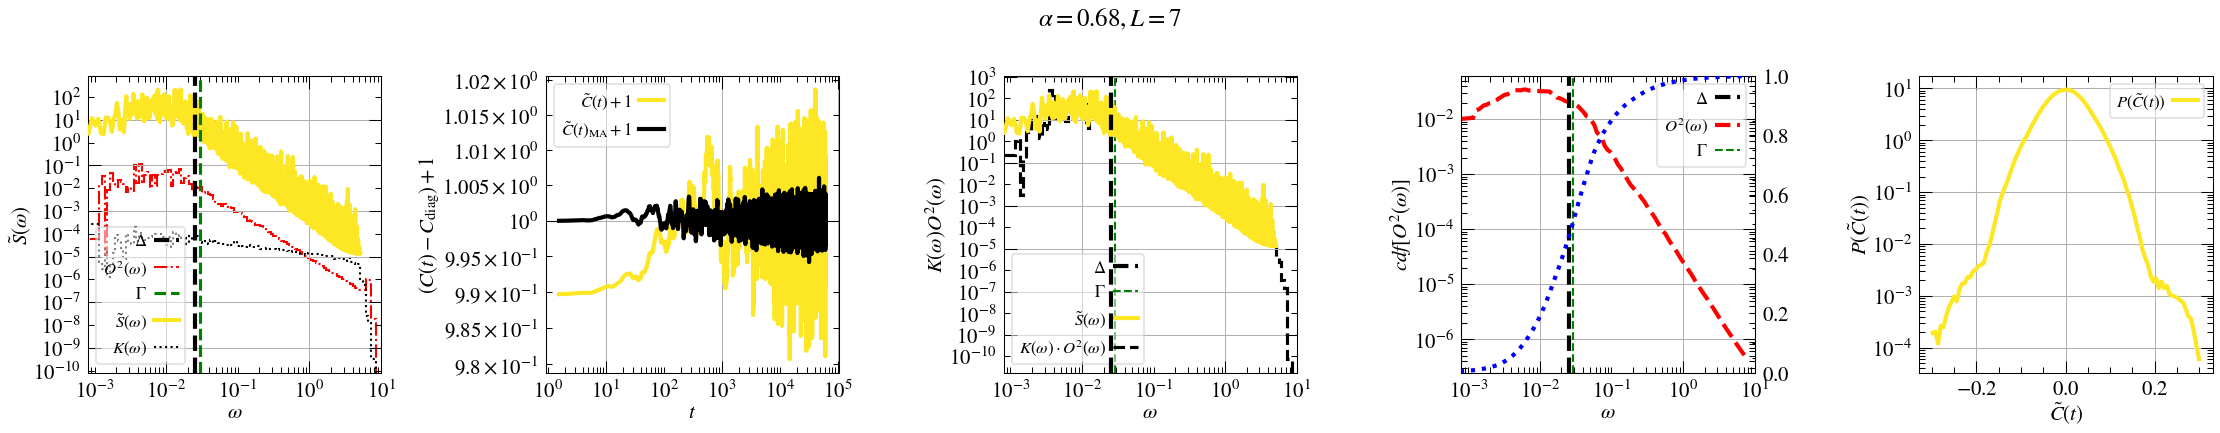

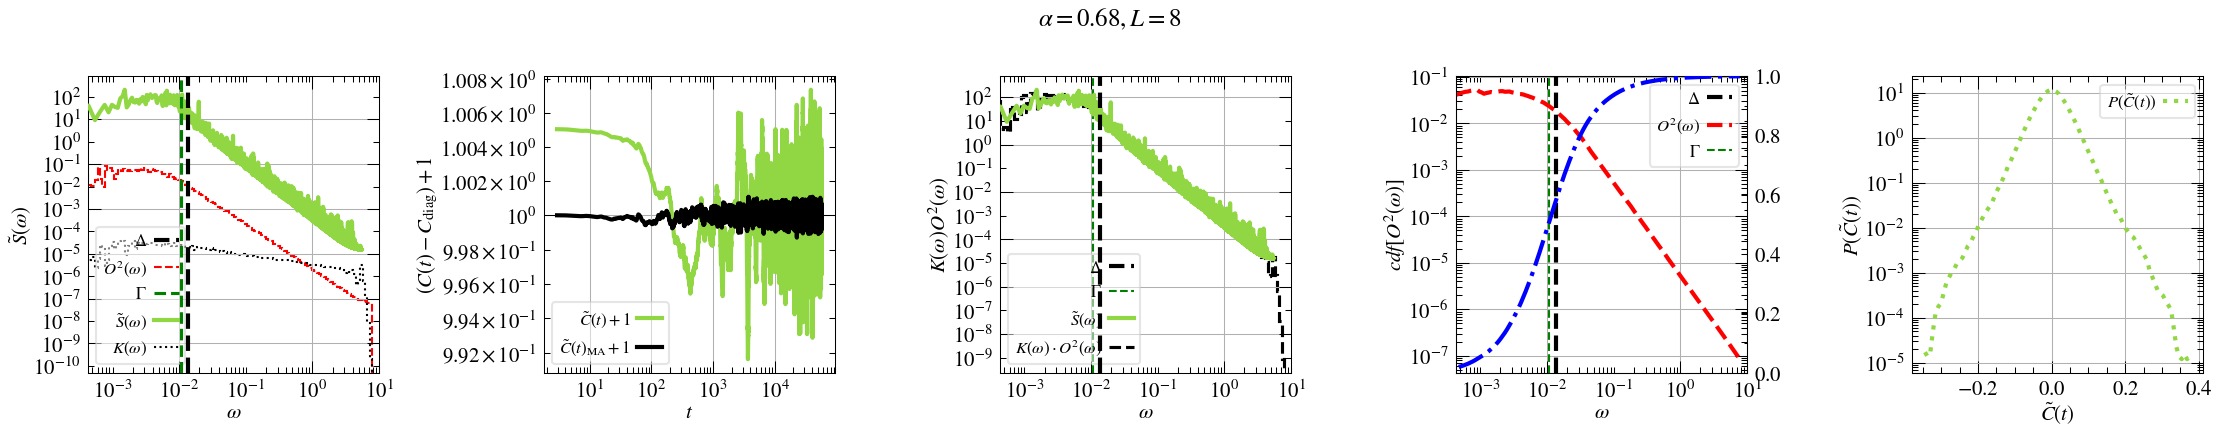

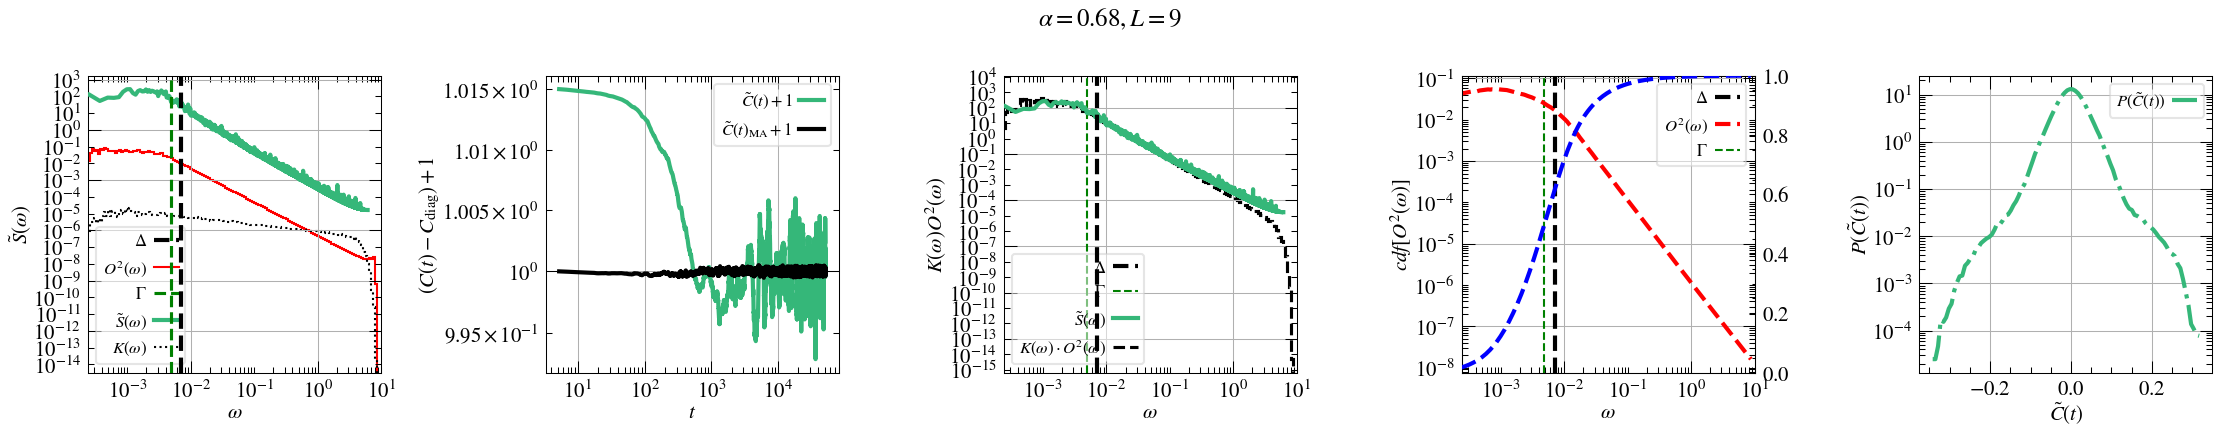

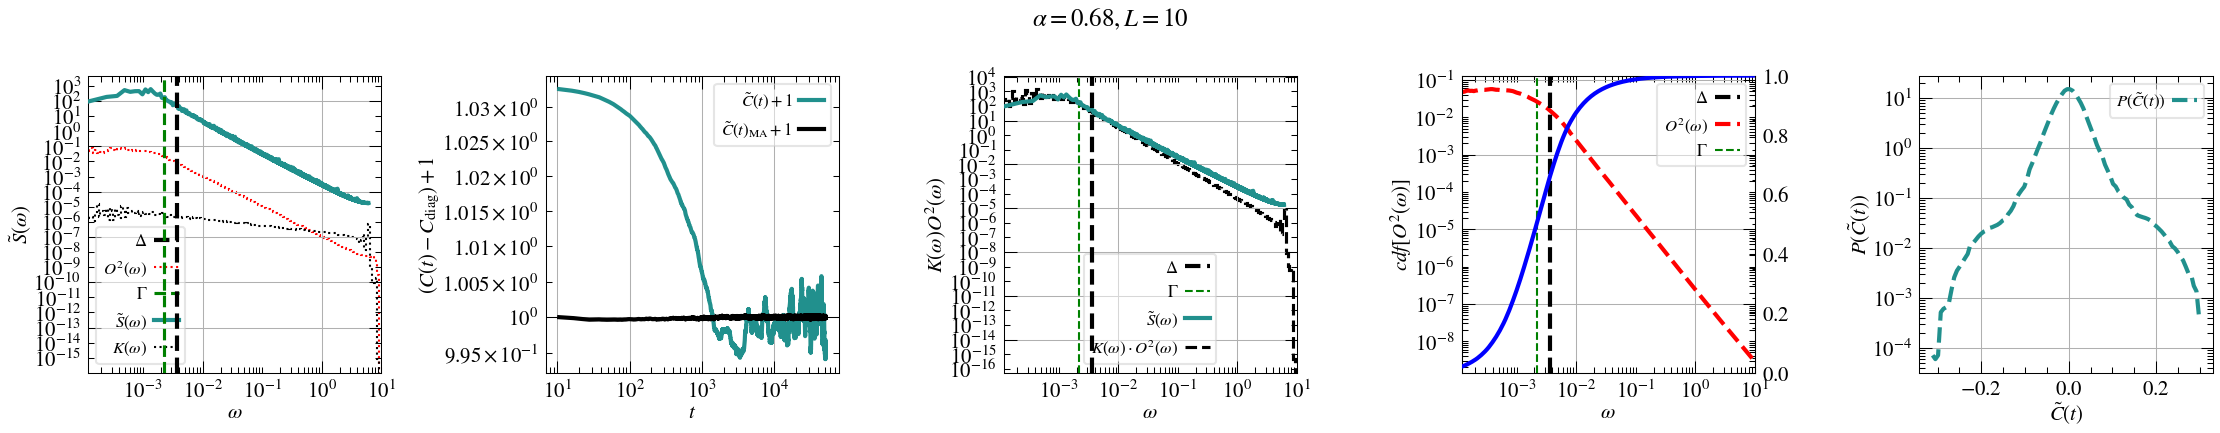

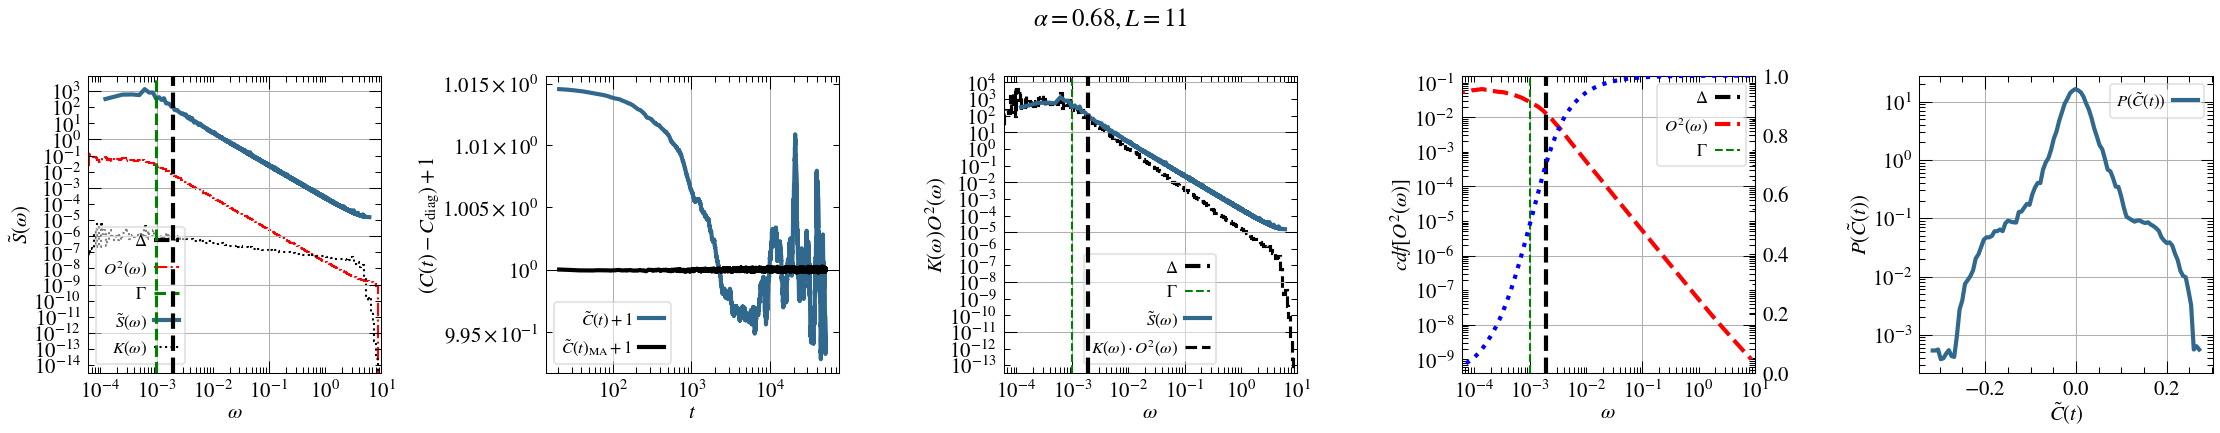

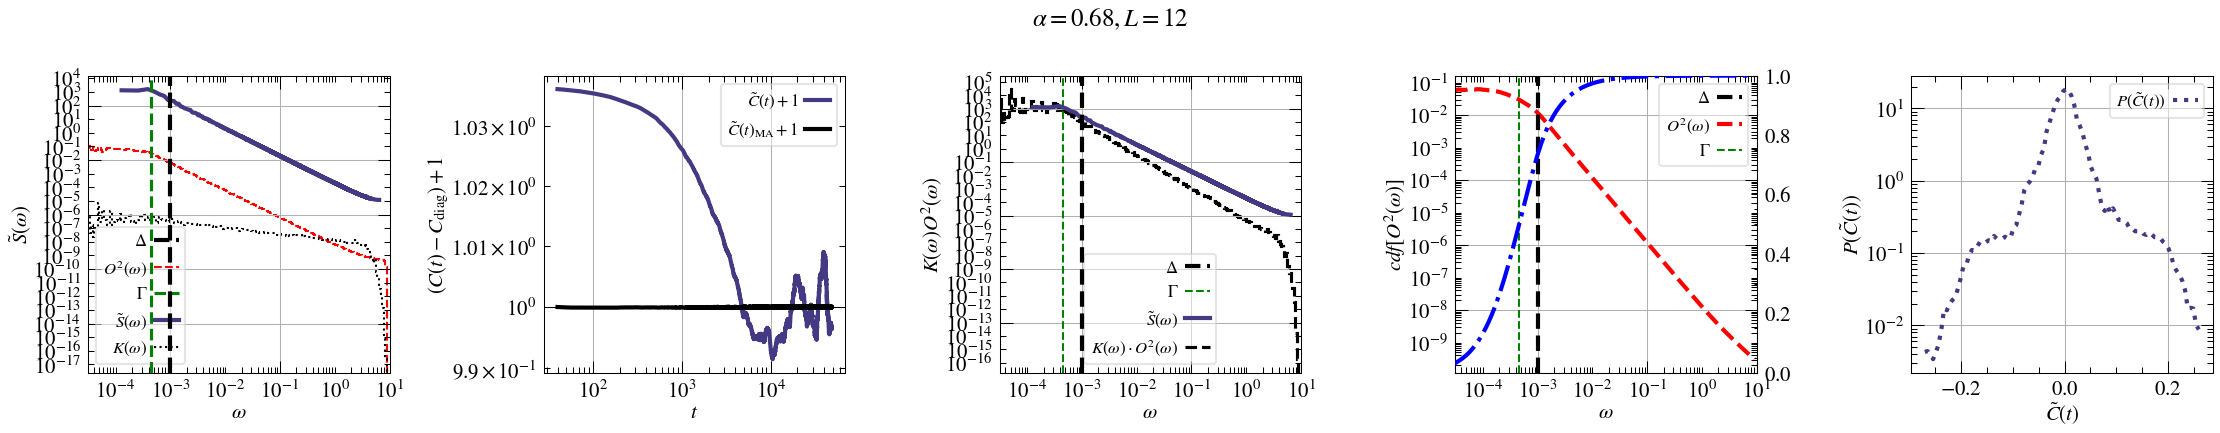

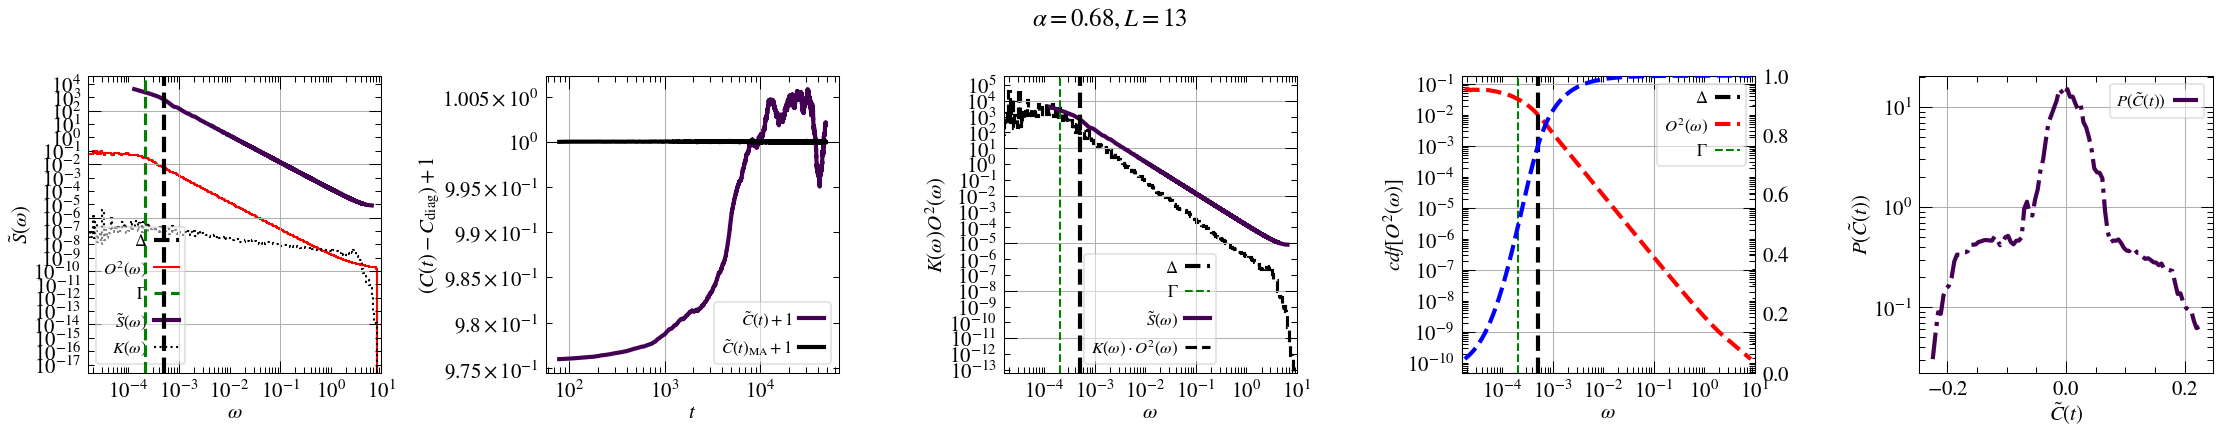

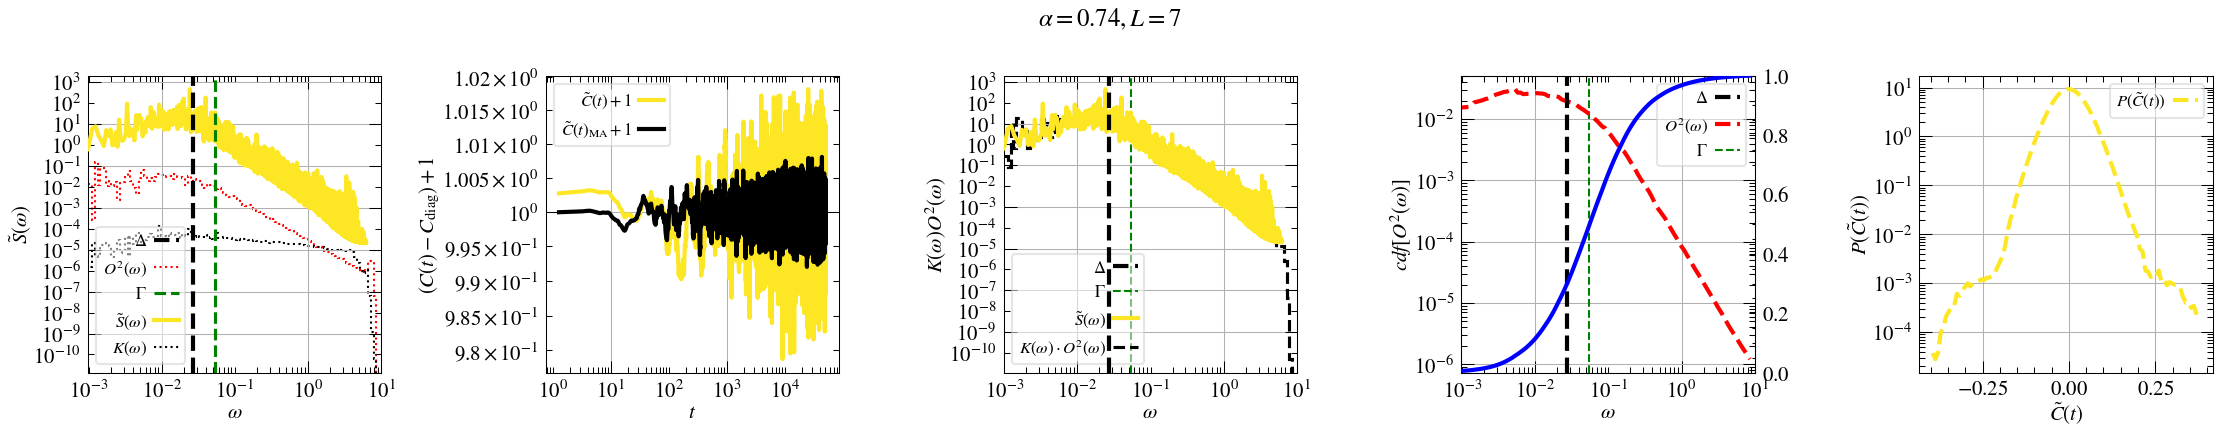

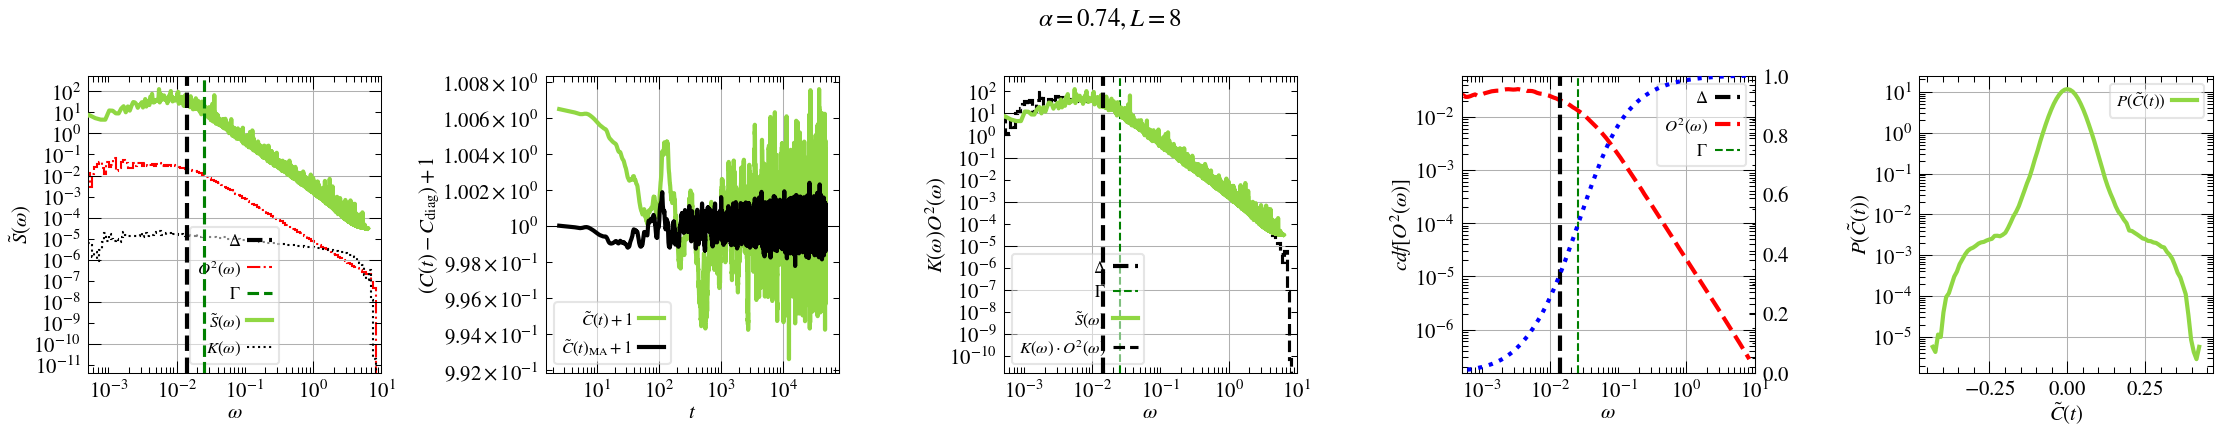

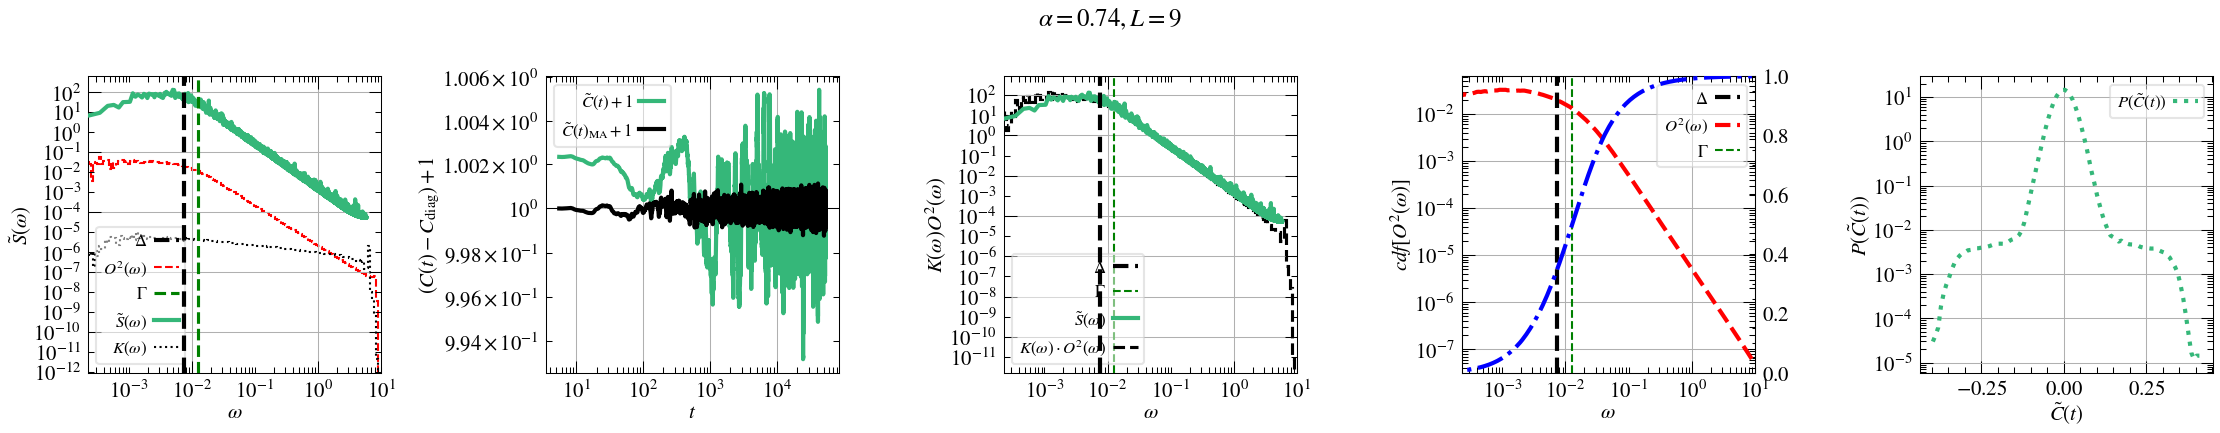

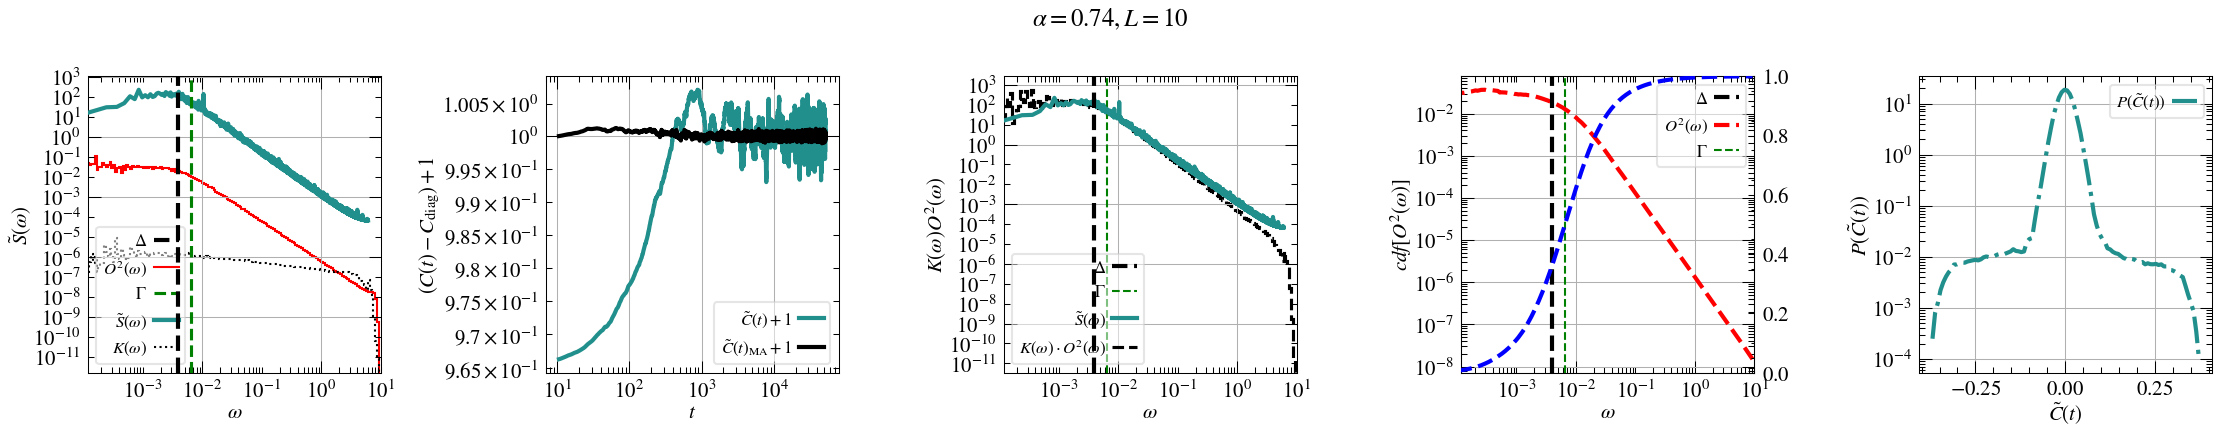

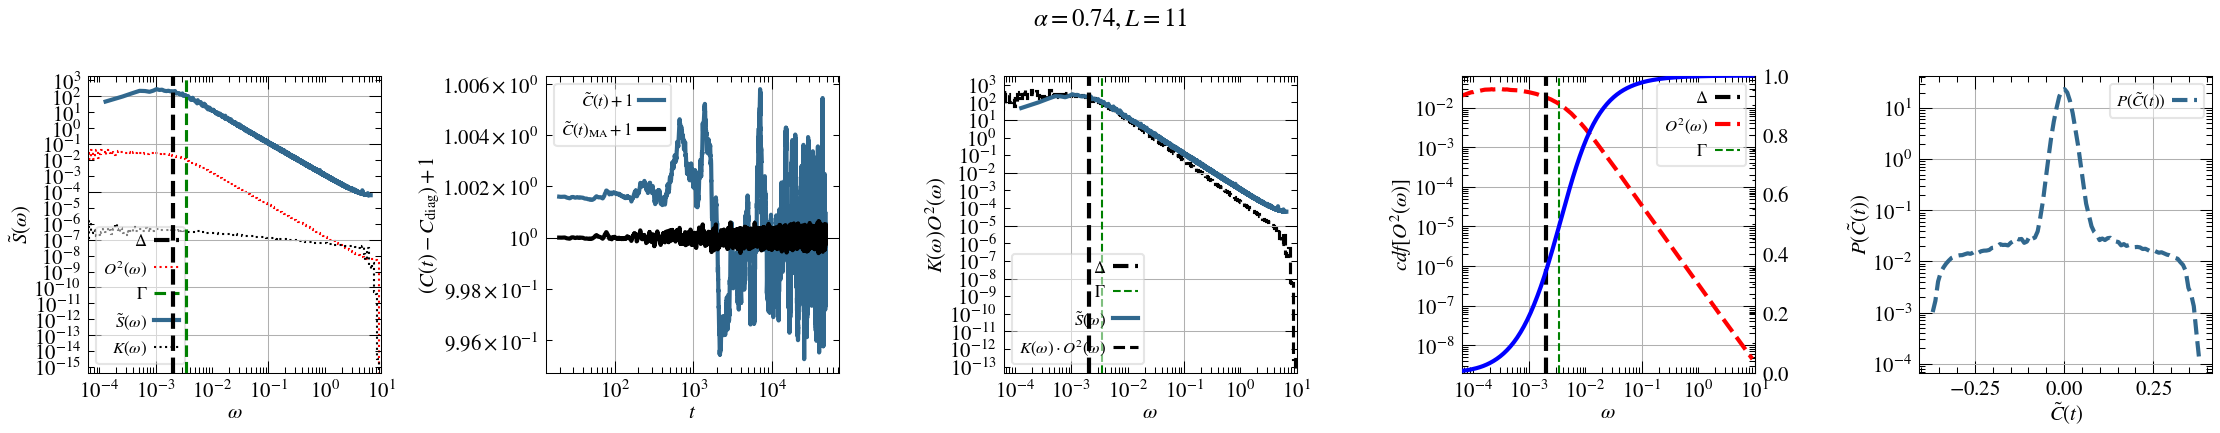

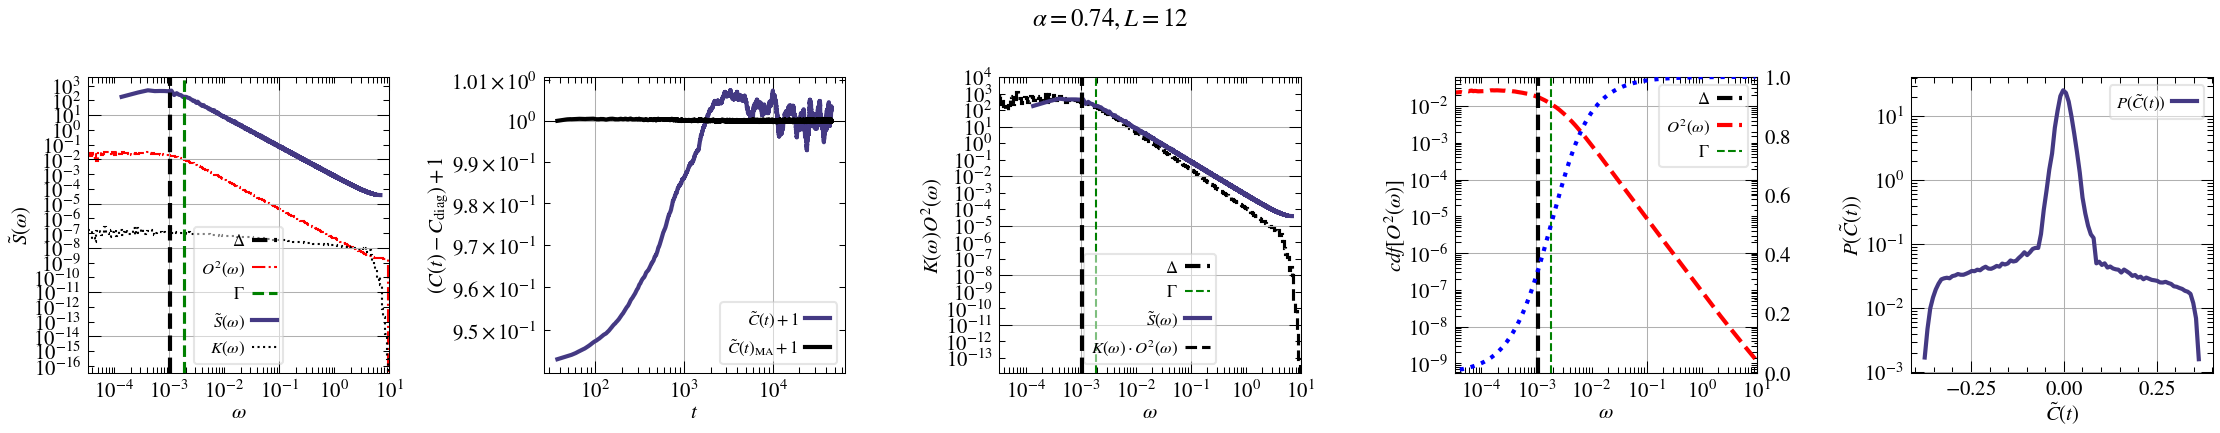

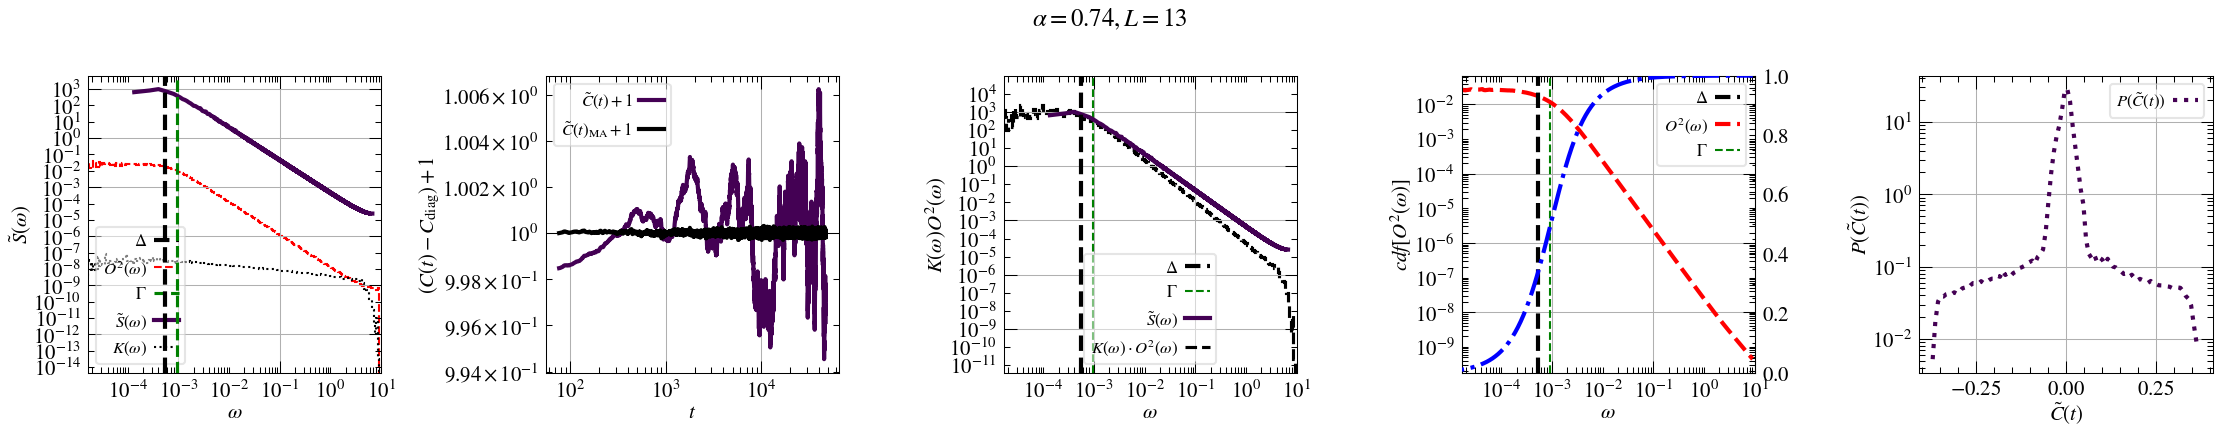

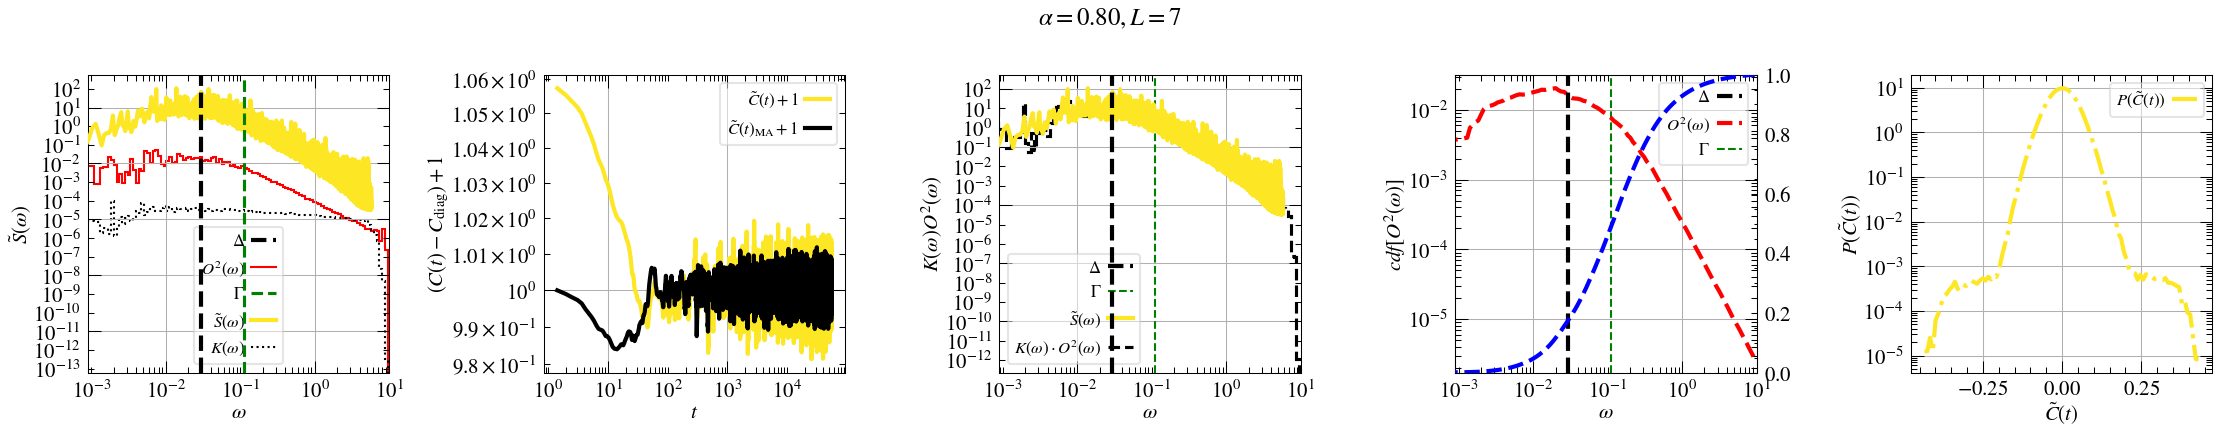

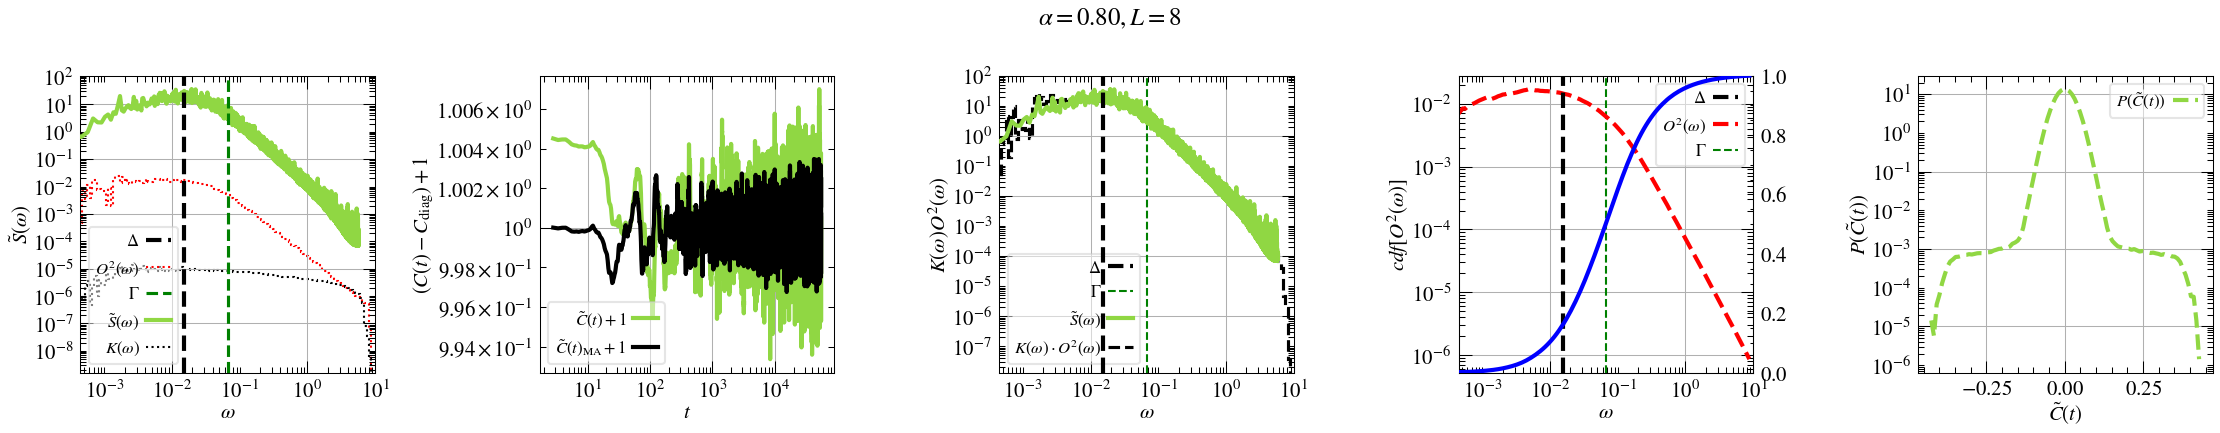

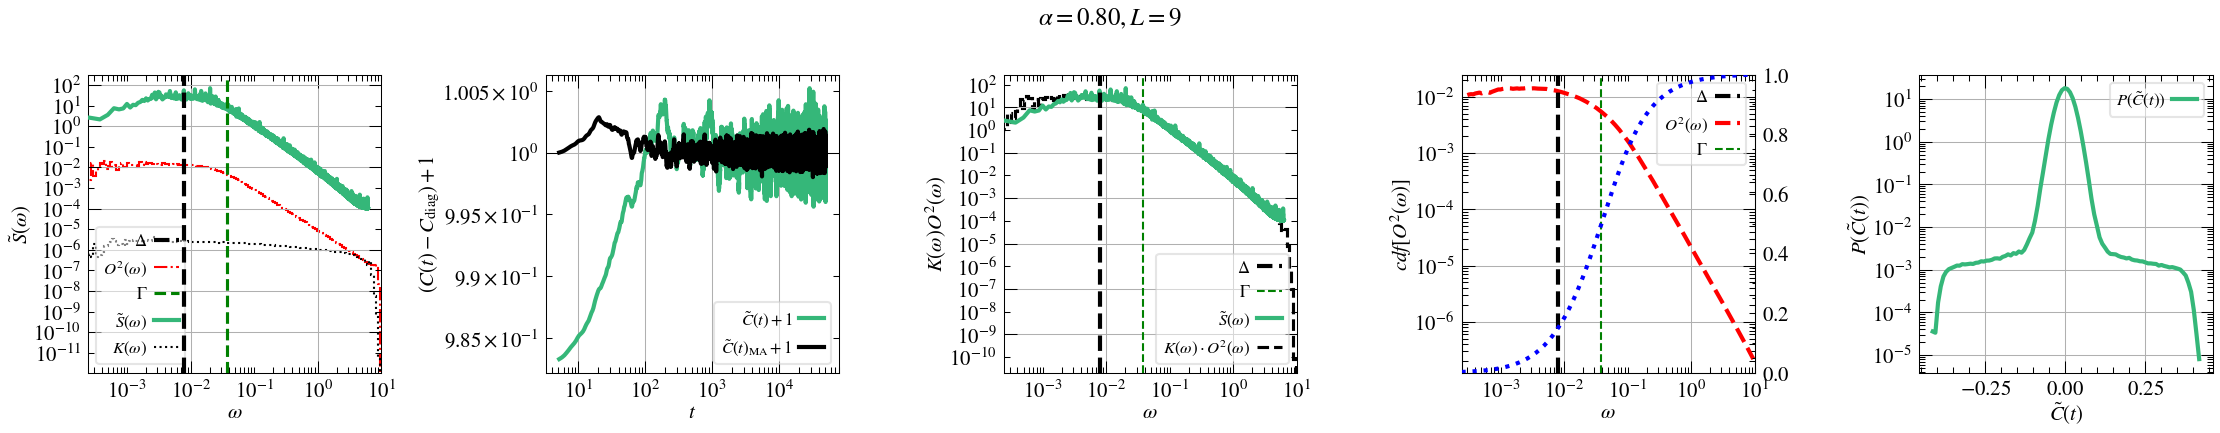

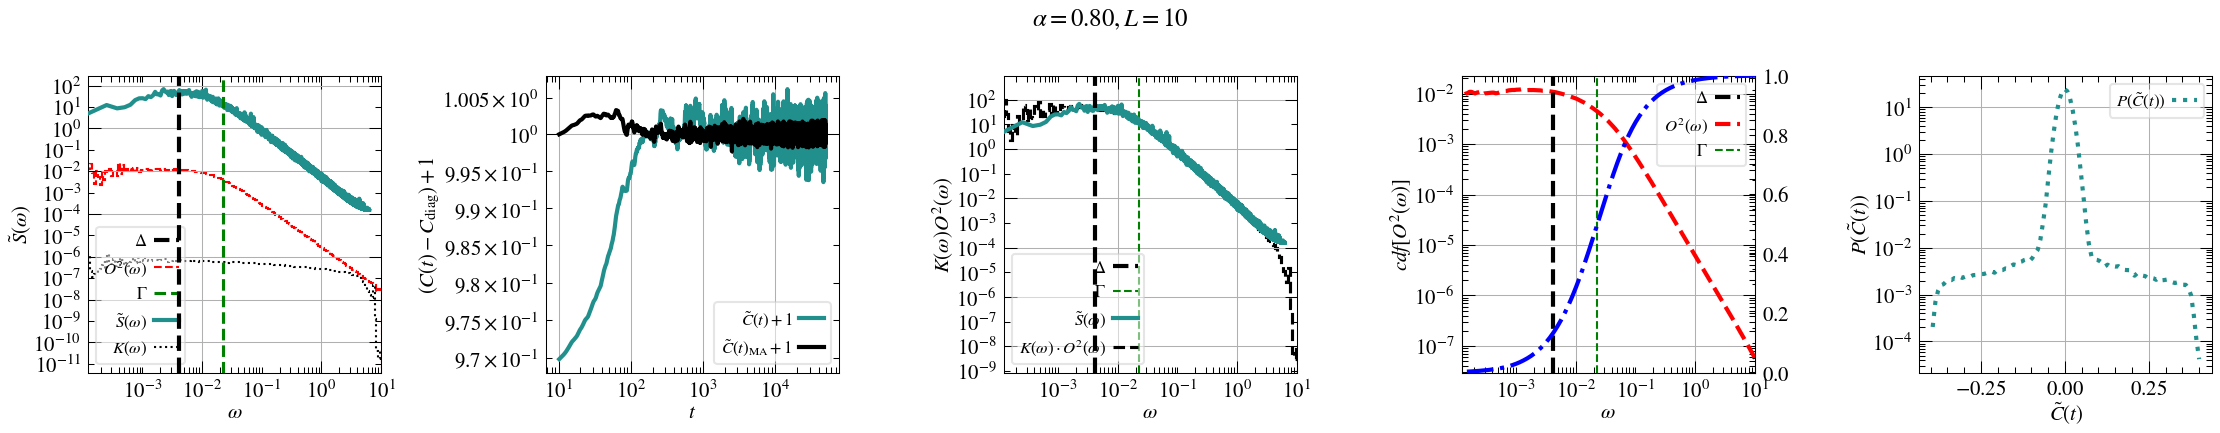

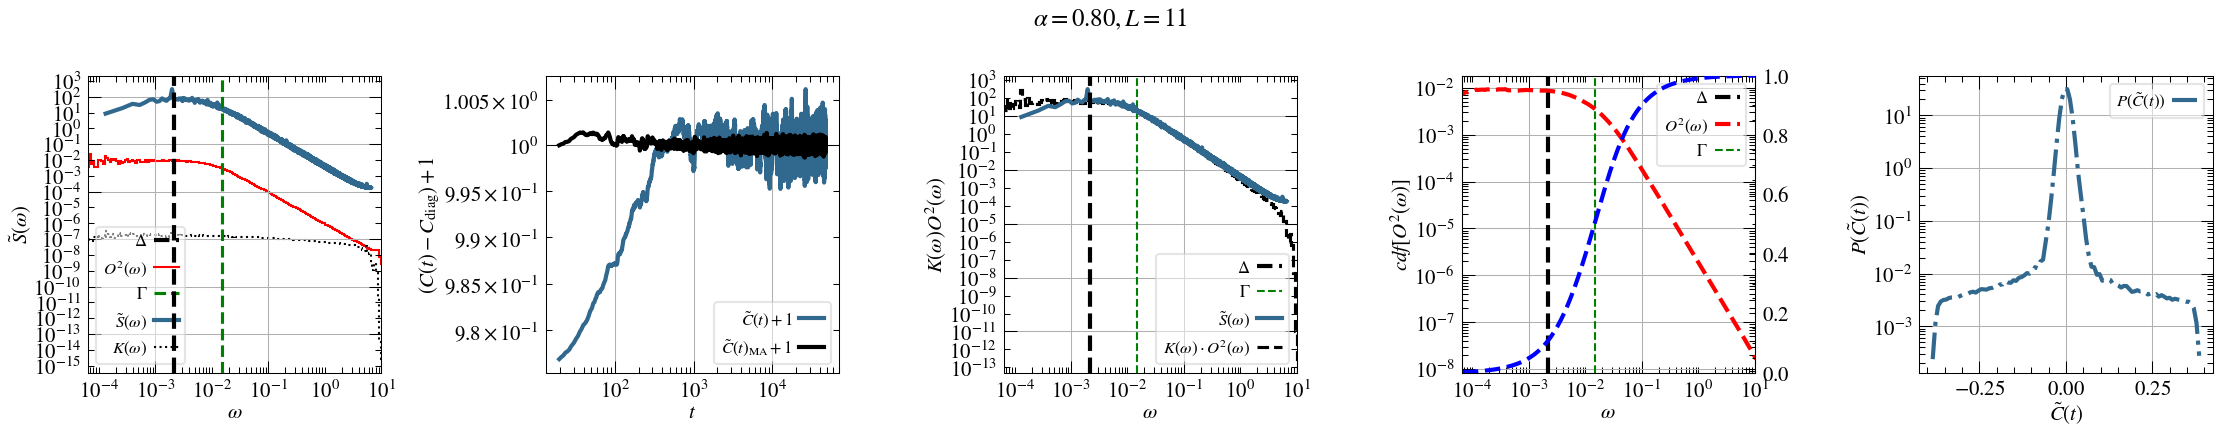

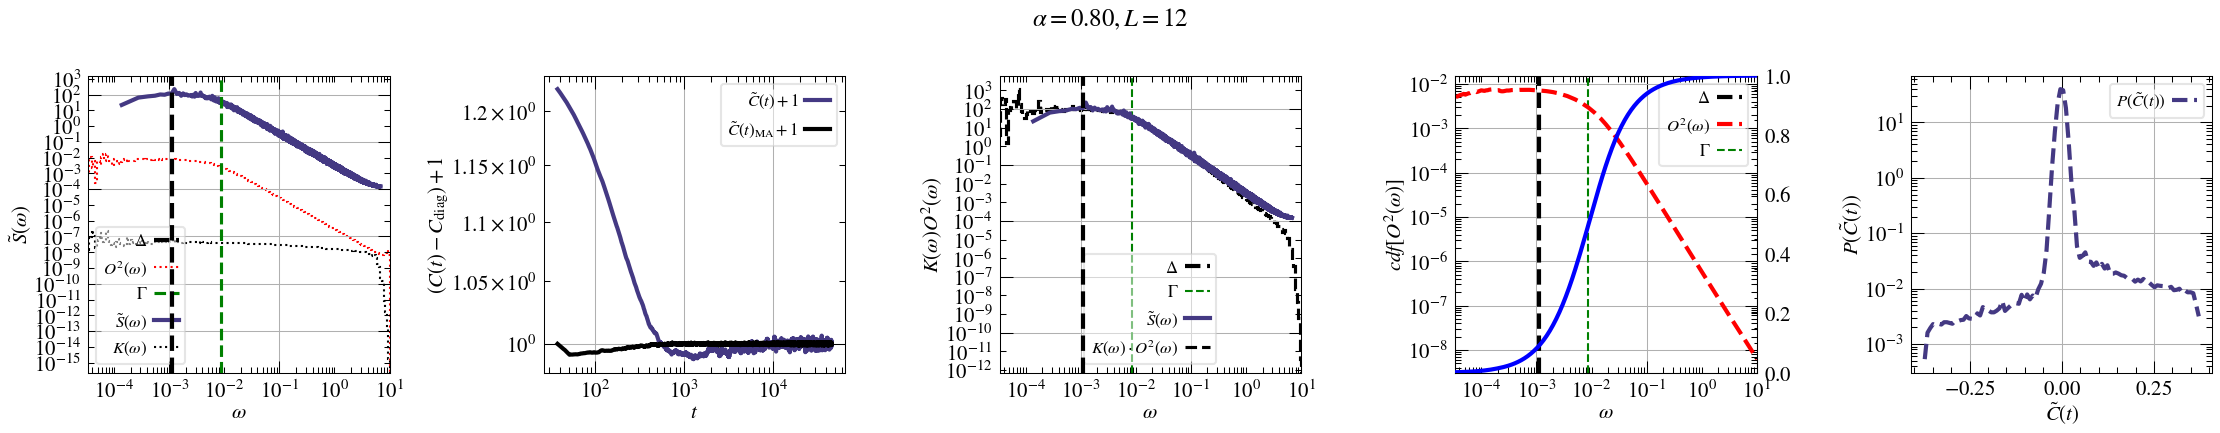

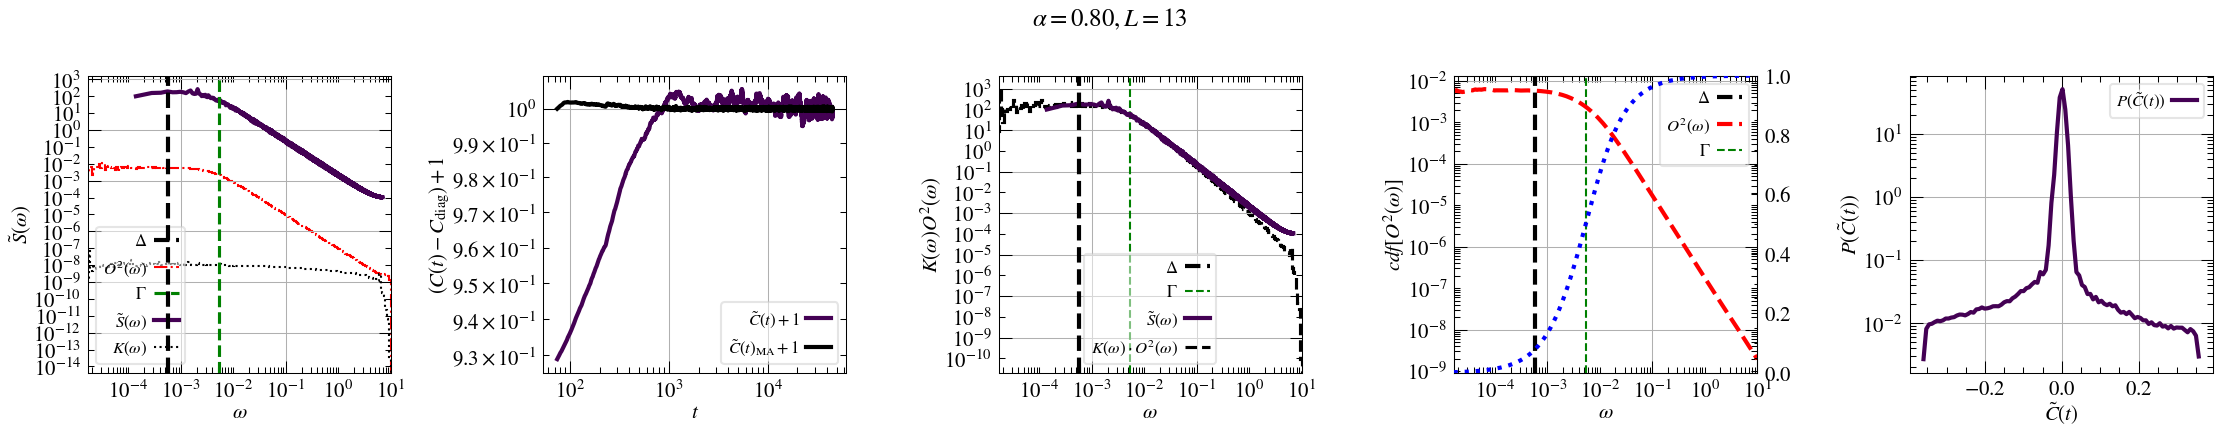

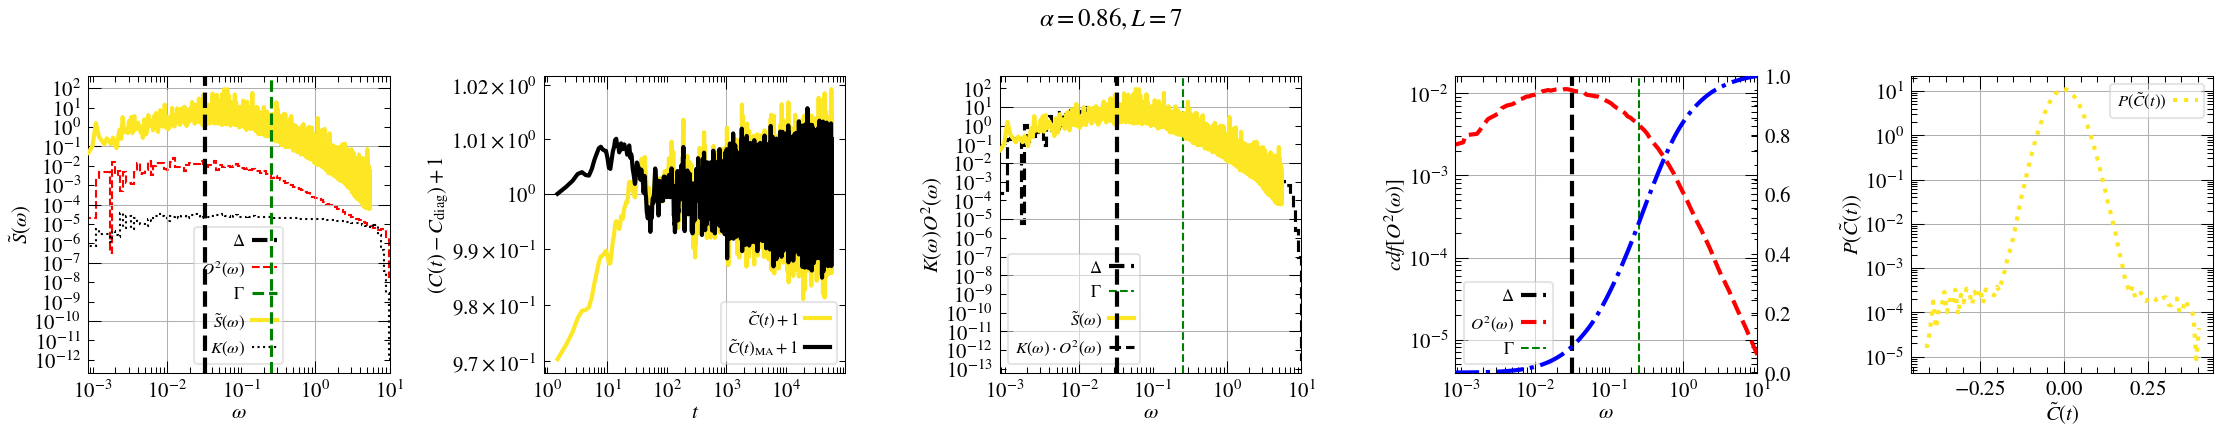

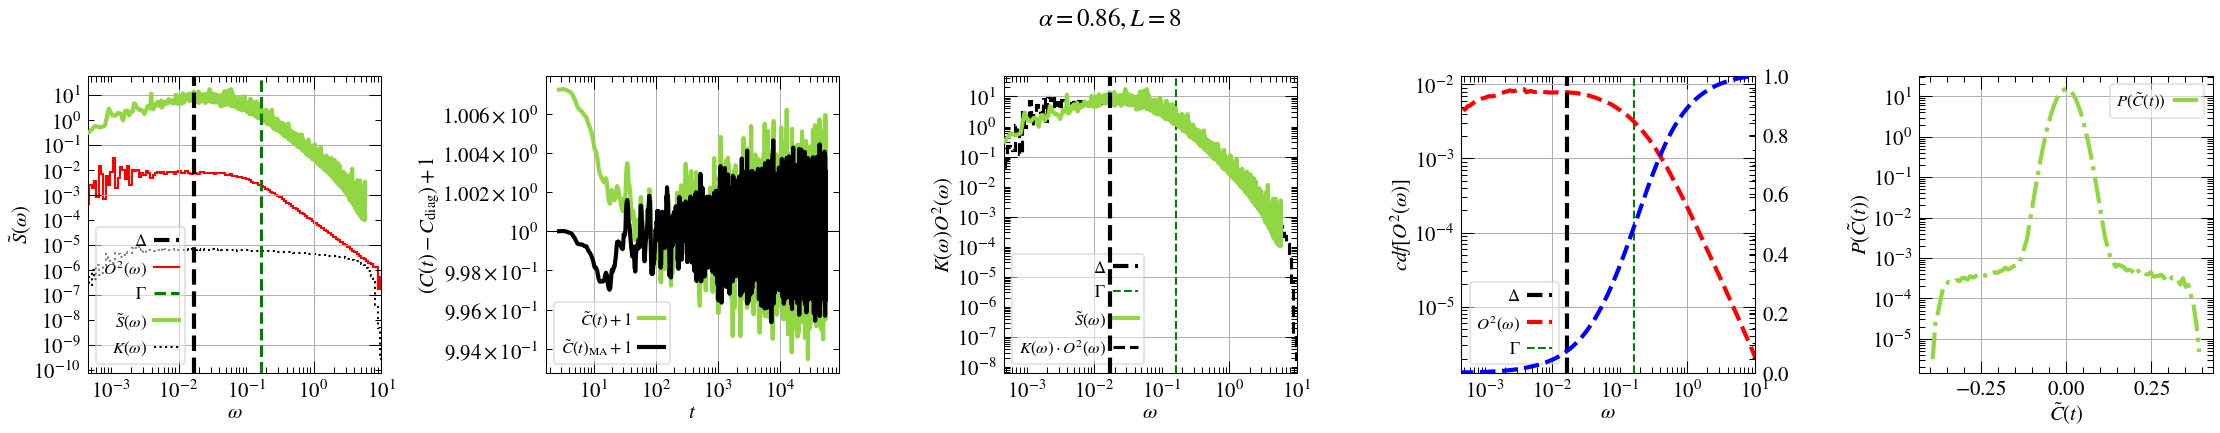

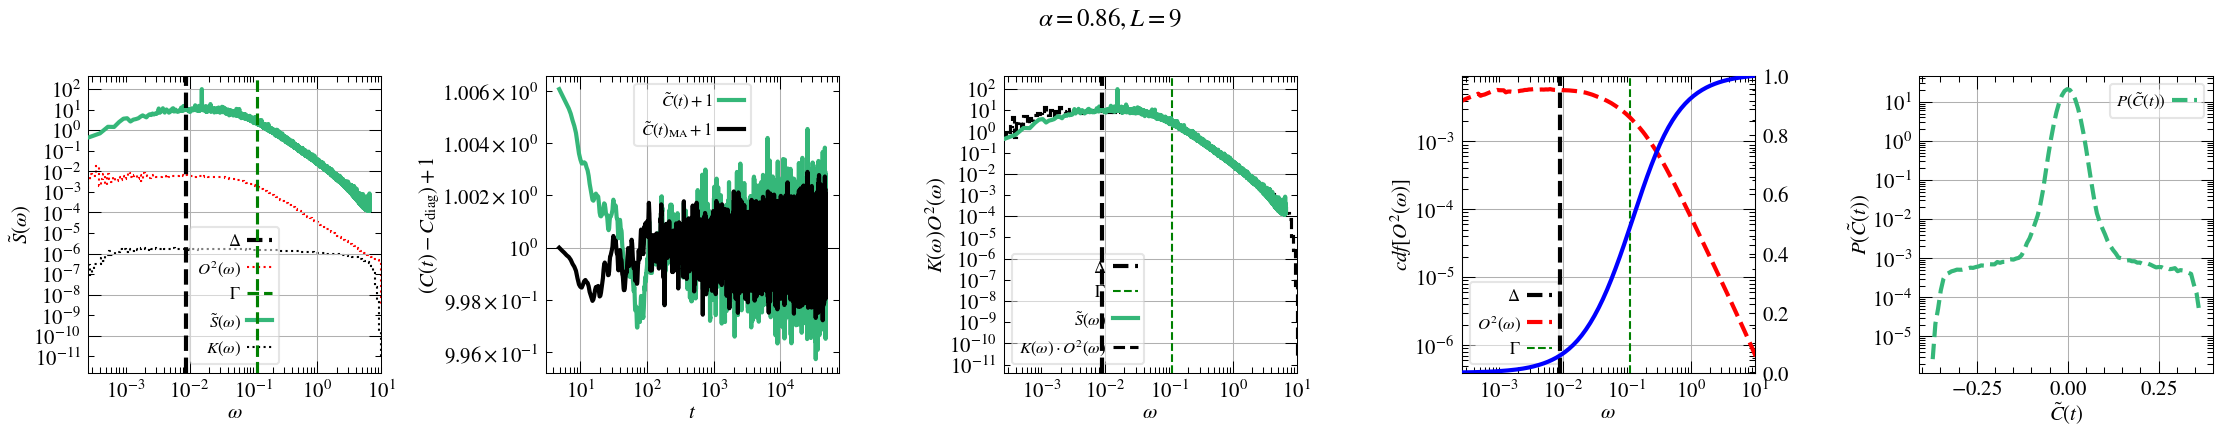

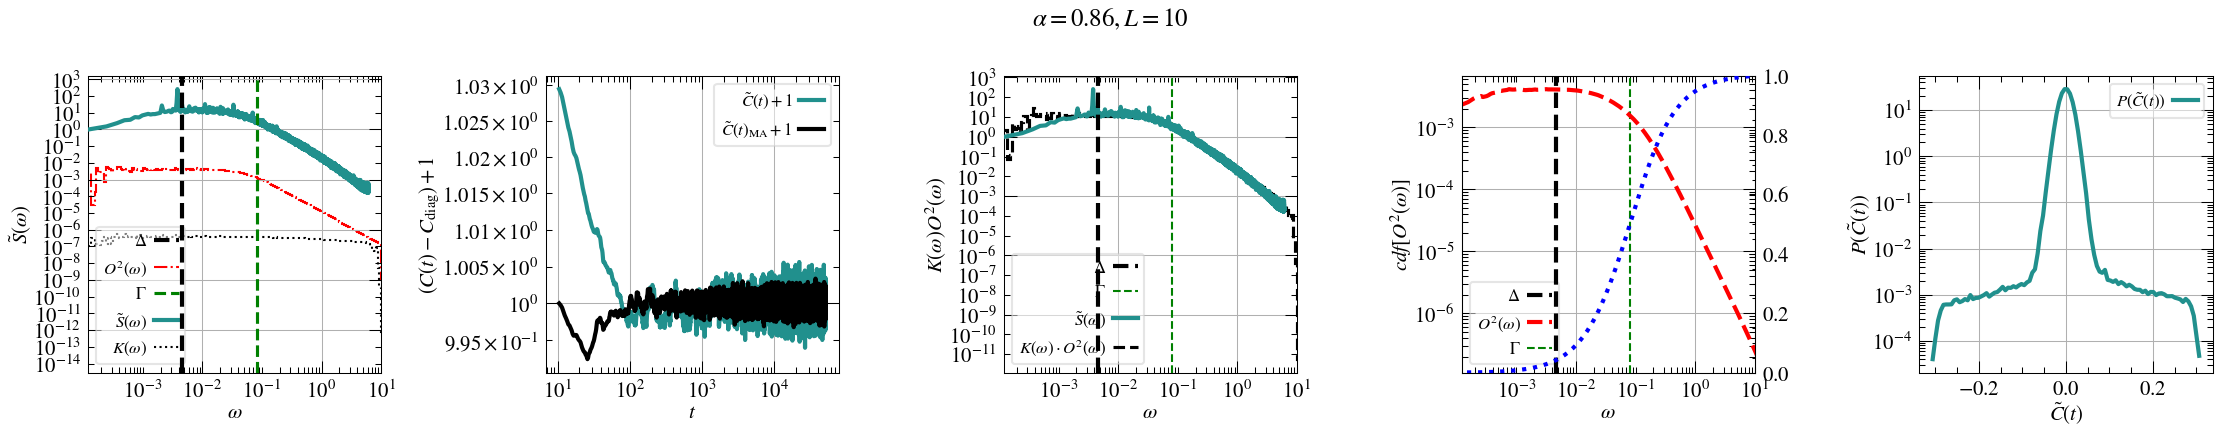

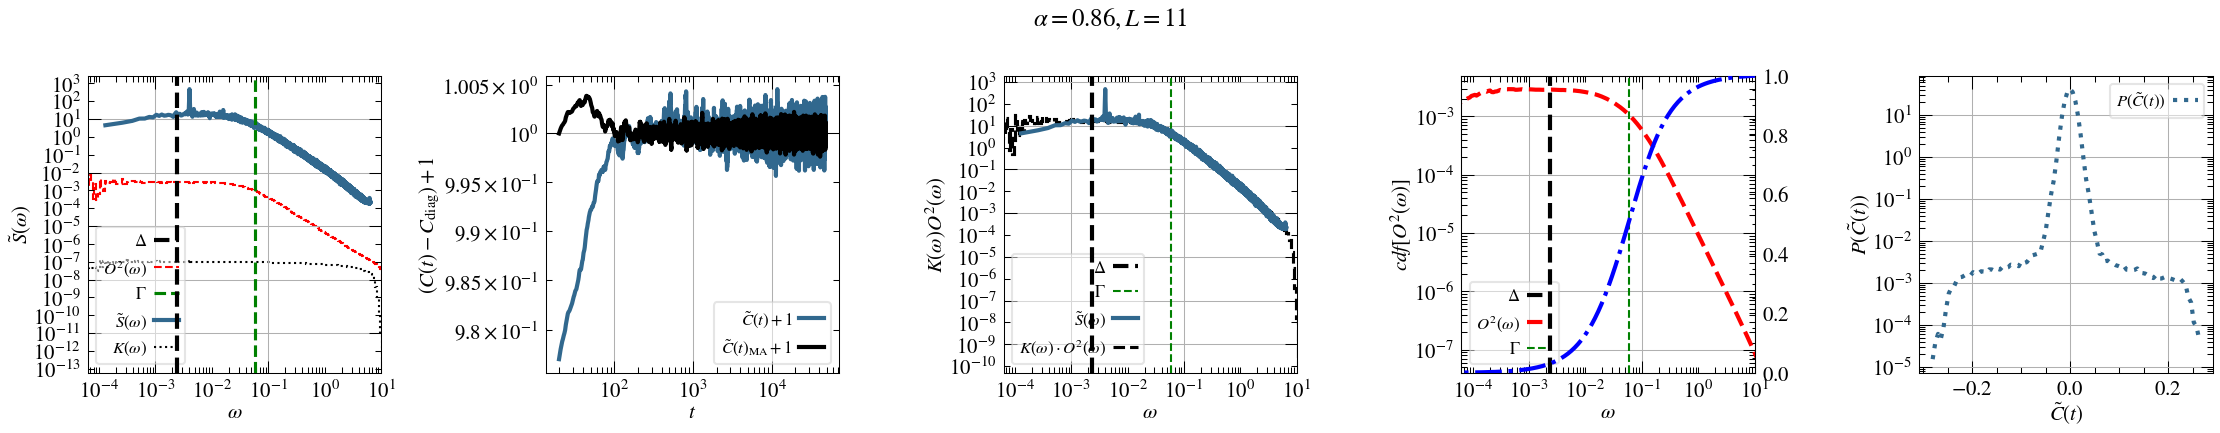

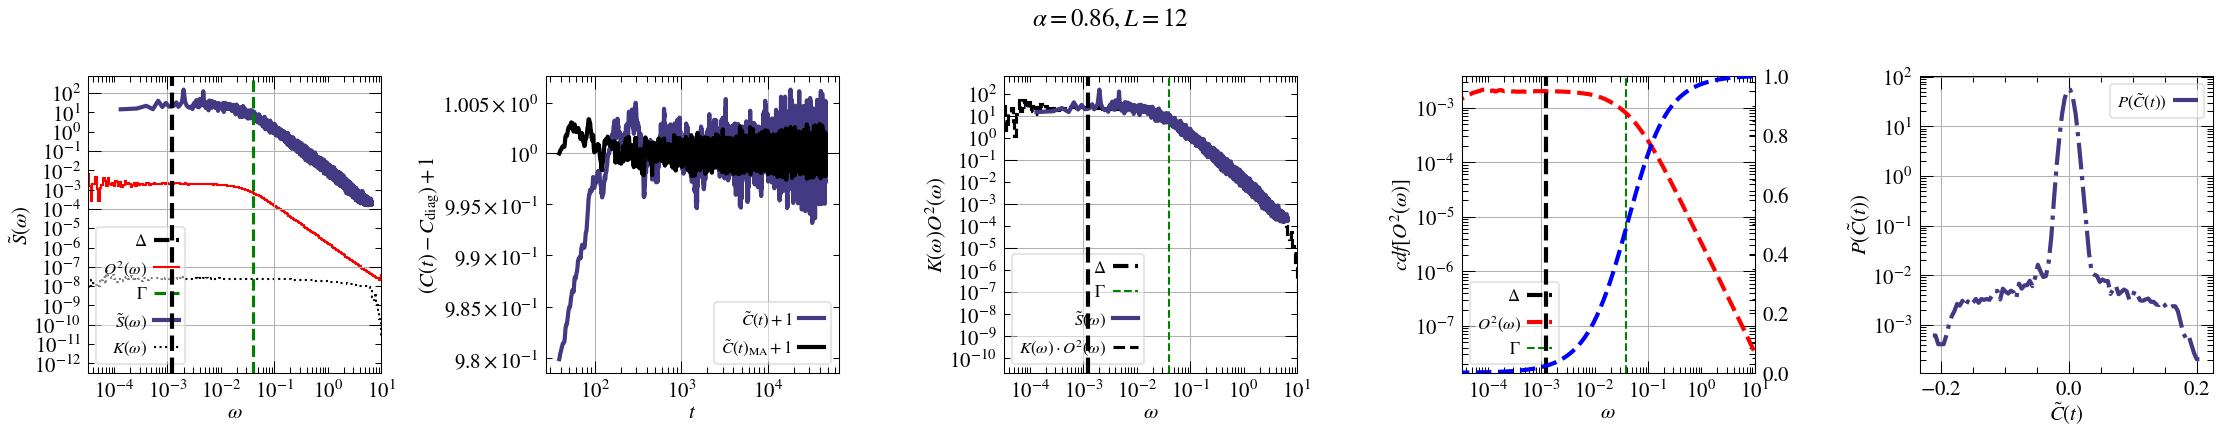

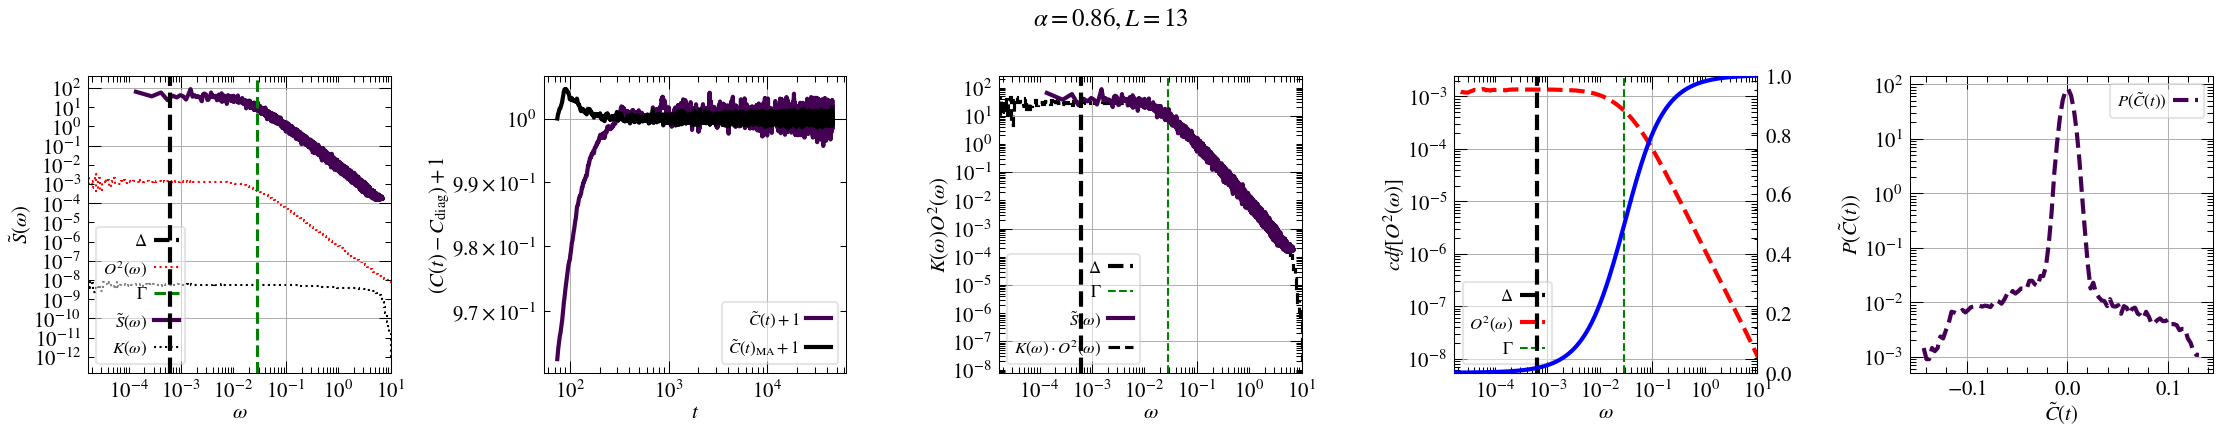

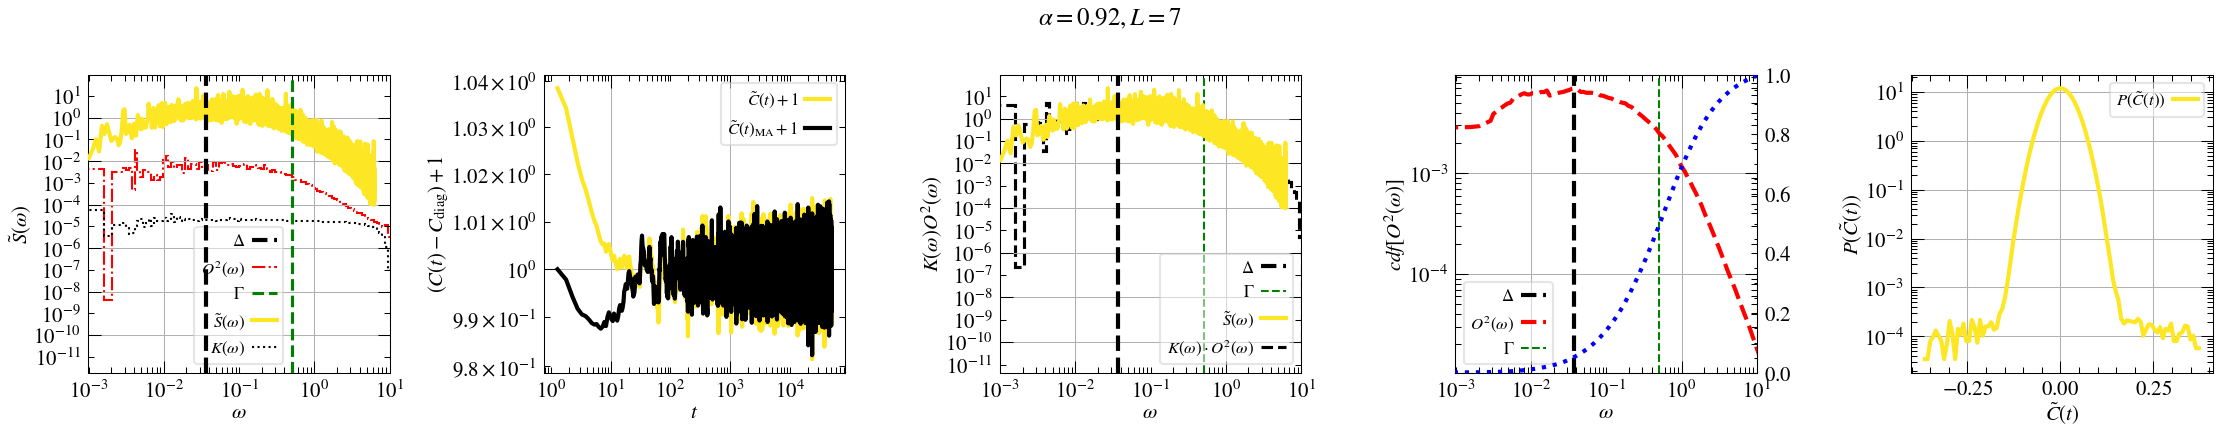

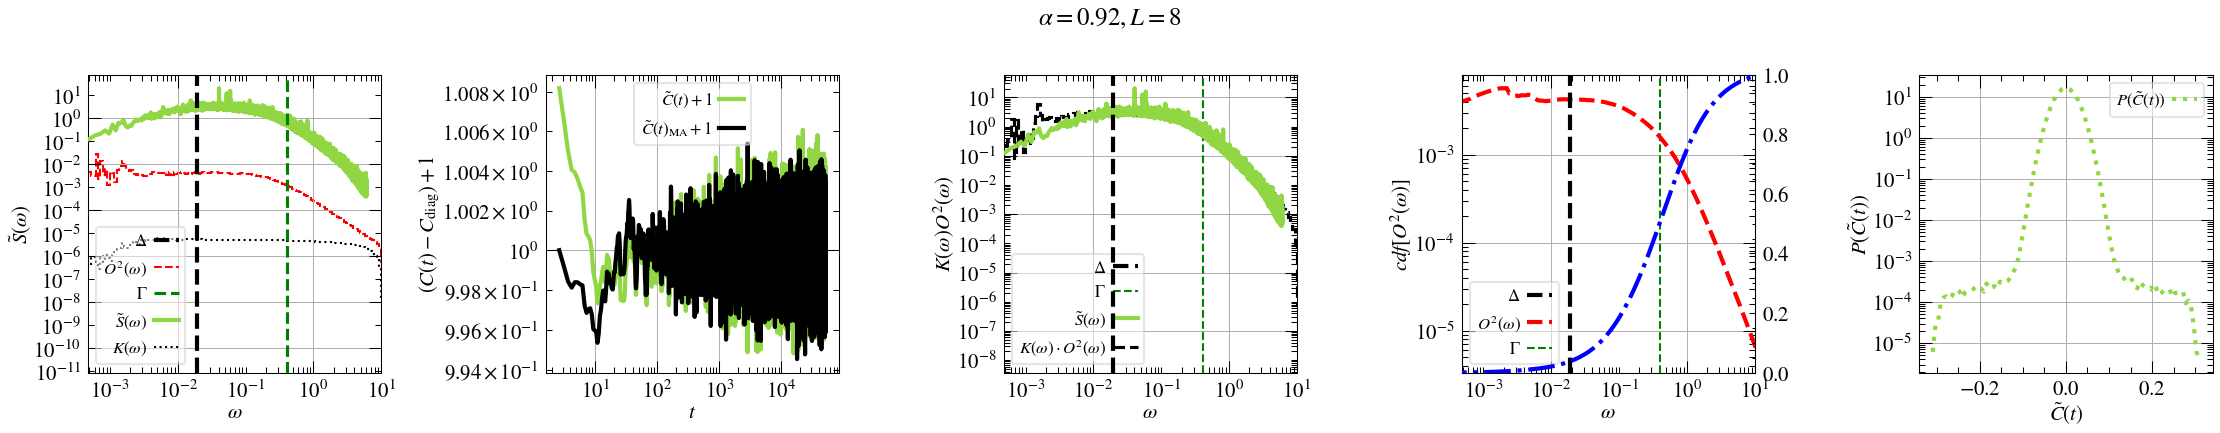

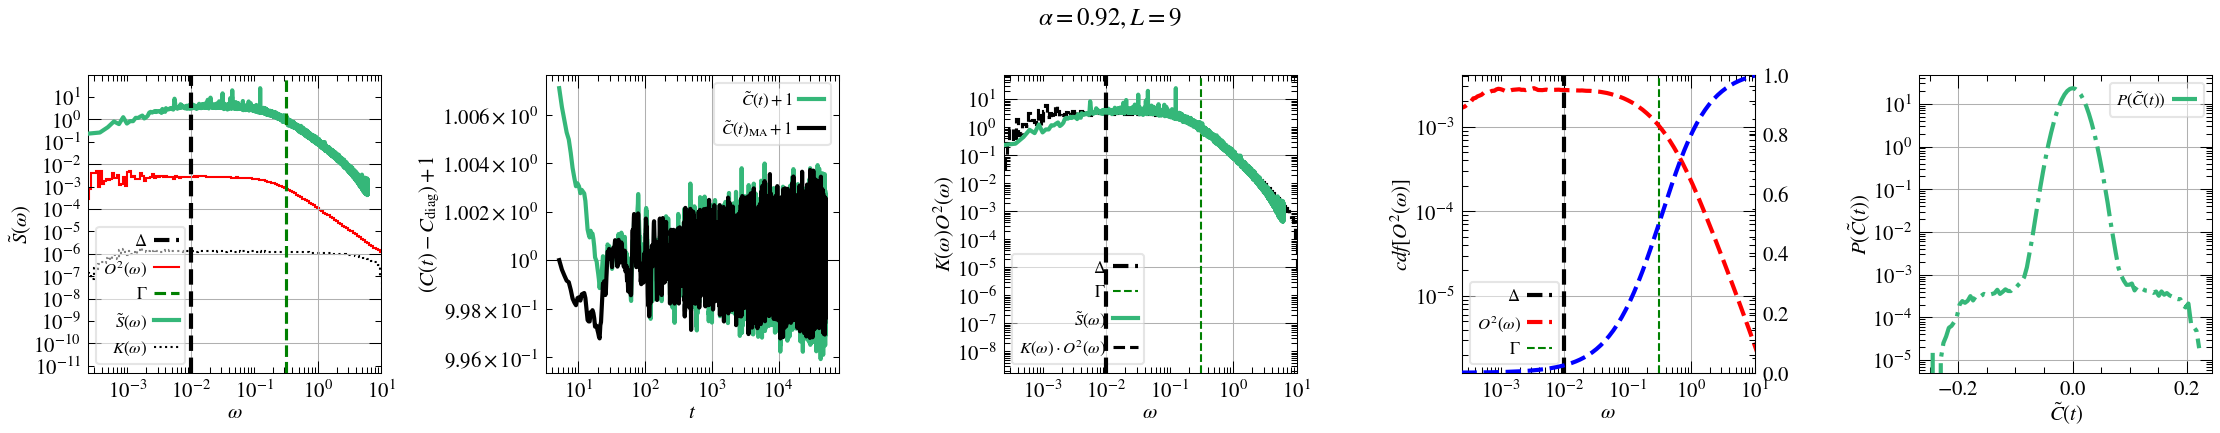

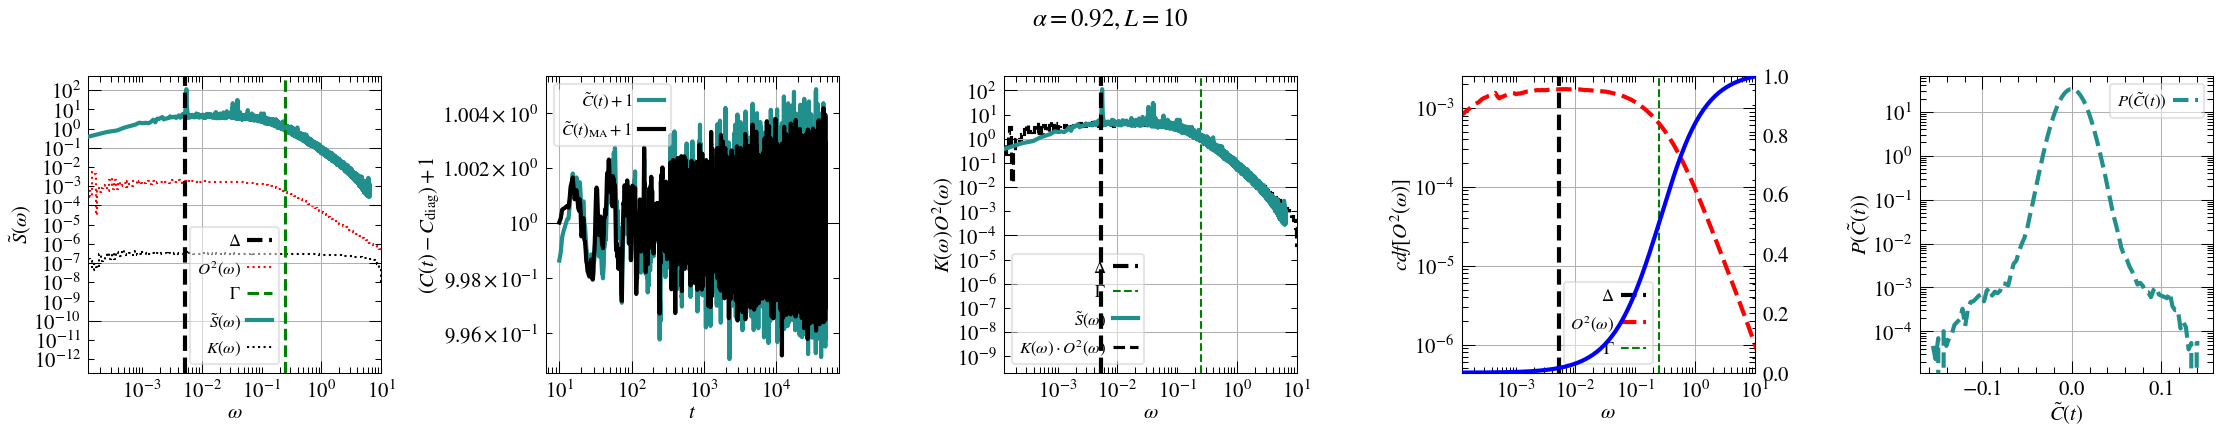

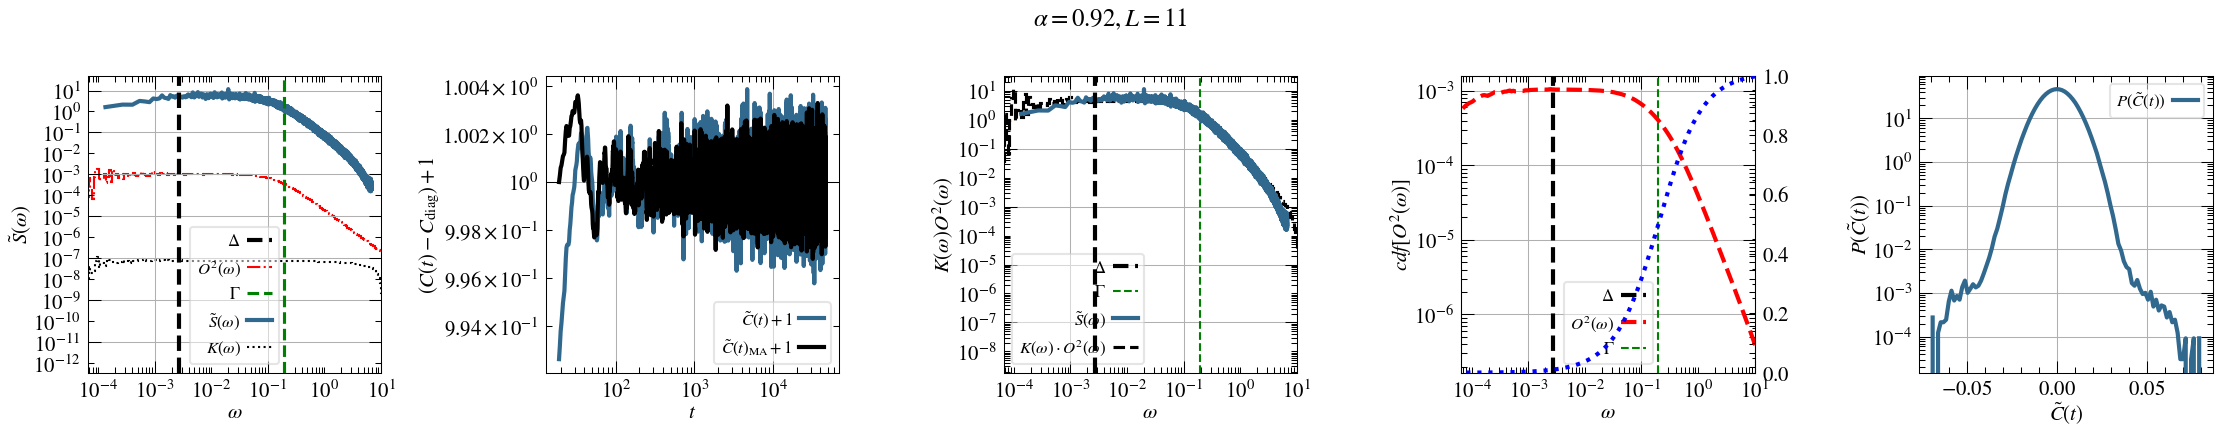

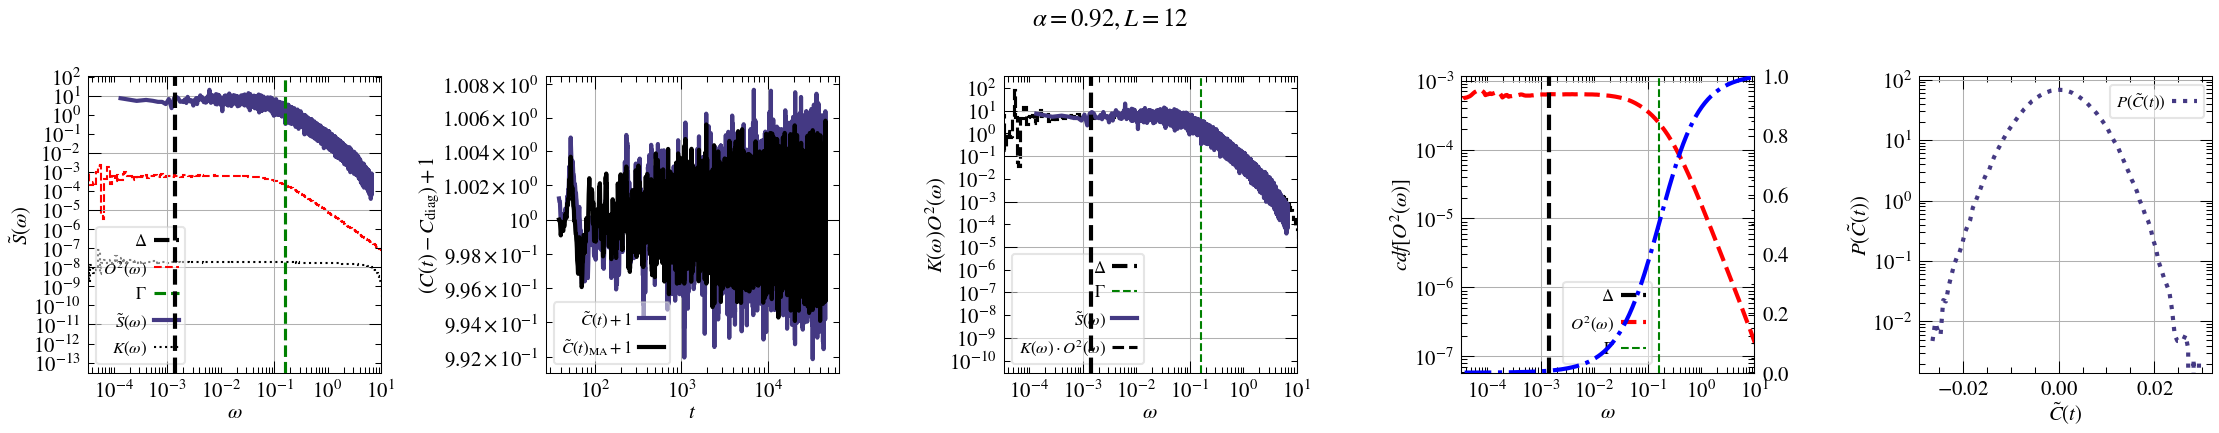

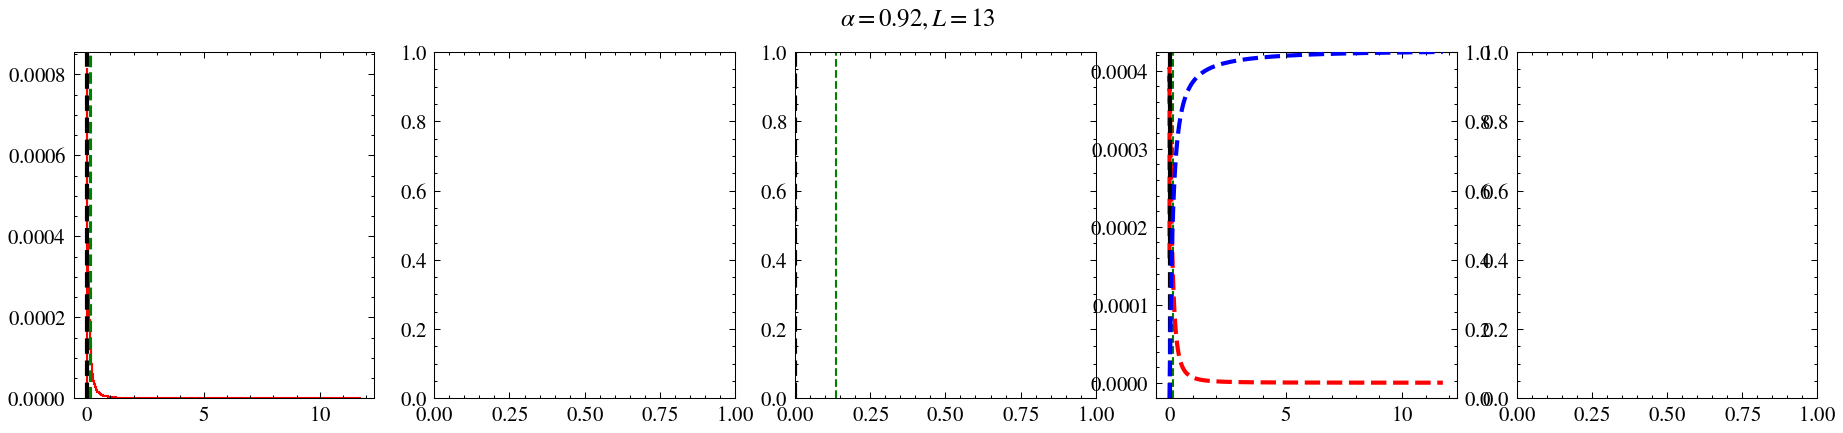

In [18]:
alphas          = np.arange(0.68, 0.95, 0.06)
# alphas          = [0.86]
sites           = np.arange(8, 15, dtype=int)
# sites           = np.arange(7, 8, dtype=int)
n               = 1
uniform         = True

directory_s     = Directories(os.curdir, 'saved', 'uniform', 'processed')
directory_s.mkdir(parents=True, exist_ok=True)
for alpha in alphas:
    for ns in sites:

        directories_python      = [Directories(os.path.abspath(data_dir), 'uniform' if uniform else 'log')]
        try:
            y, fig, ax              = get_results_single(directories_python =   directories_python,
                                                        alpha               =   alpha,
                                                        ns                  =   ns,
                                                        n                   =   n,
                                                        uniform             =   True)
        except Exception as e:
            logger.error(f"Error processing alpha {alpha:.2f}, ns {ns}, n {n}: {e}", color='red')
            continue
        HDF5Manager.save_data_to_file(directory=directory_s, filename = f'alpha_{alpha:.2f}_ns_{ns}_n_{n}.h5', data_to_save=y)
        plt.savefig(directory_s / f'alpha_{alpha:.2f}_ns_{ns}_n_{n}.png', dpi=150)
        plt.savefig(directory_s / f'alpha_{alpha:.2f}_ns_{ns}_n_{n}.pdf', dpi=150)